### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_2/'
summaries_path = cur_dir + 'summaries_2_2/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 2
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.52499998], average train loss: 0.719455, average train accuracy: 0.752930
epoch: 2, iter: 0/8, validation accuracies: [0.55000001], average train loss: 0.194965, average train accuracy: 0.921875
epoch: 3, iter: 0/8, validation accuracies: [0.80000001], average train loss: 0.080199, average train accuracy: 0.970703
epoch: 4, iter: 0/8, validation accuracies: [0.94999999], average train loss: 0.059377, average train accuracy: 0.976562
epoch: 5, iter: 0/8, validation accuracies: [1.], average train loss: 0.066859, average train accuracy: 0.973633
epoch: 6, iter: 0/8, validation accuracies: [1.], average train loss: 0.043862, average train accuracy: 0.985352
epoch: 7, iter: 0/8, validation accuracies: [1.], average train loss: 0.054508, average train accuracy: 0.976562
epoch: 8, iter:

epoch: 69, iter: 0/8, validation accuracies: [1.], average train loss: 0.014216, average train accuracy: 0.993164
epoch: 70, iter: 0/8, validation accuracies: [1.], average train loss: 0.009780, average train accuracy: 0.996094
epochs: 70.000000, final train loss: 0.010977, validation accuracies: [1.]
best epochs: 5.000000, best_avg: 1.000000, validation accuracies: [1.]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.41895127296447754
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1
Restoring param

epoch: 52, iter: 0/8, validation accuracies: [0.92500001 0.85000002], average train loss: 0.321474, average train accuracy: 0.879883
epoch: 53, iter: 0/8, validation accuracies: [0.97500002 0.85000002], average train loss: 0.343753, average train accuracy: 0.876953
epoch: 54, iter: 0/8, validation accuracies: [0.94999999 0.85000002], average train loss: 0.370726, average train accuracy: 0.862305
epoch: 55, iter: 0/8, validation accuracies: [0.94999999 0.875     ], average train loss: 0.309933, average train accuracy: 0.885742
epoch: 56, iter: 0/8, validation accuracies: [1.         0.85000002], average train loss: 0.298110, average train accuracy: 0.890625
epoch: 57, iter: 0/8, validation accuracies: [0.94999999 0.85000002], average train loss: 0.313278, average train accuracy: 0.888672
epoch: 58, iter: 0/8, validation accuracies: [0.94999999 0.875     ], average train loss: 0.347884, average train accuracy: 0.876953
epoch: 59, iter: 0/8, validation accuracies: [1.         0.82499999],

epoch: 32, iter: 0/8, validation accuracies: [0.89999998 0.67500001 0.5       ], average train loss: 0.839523, average train accuracy: 0.647461
epoch: 33, iter: 0/8, validation accuracies: [0.92500001 0.60000002 0.34999999], average train loss: 0.871592, average train accuracy: 0.648438
epoch: 34, iter: 0/8, validation accuracies: [0.92500001 0.64999998 0.44999999], average train loss: 0.828883, average train accuracy: 0.655273
epoch: 35, iter: 0/8, validation accuracies: [0.875      0.69999999 0.32499999], average train loss: 0.865149, average train accuracy: 0.635742
epoch: 36, iter: 0/8, validation accuracies: [0.89999998 0.57499999 0.57499999], average train loss: 0.835297, average train accuracy: 0.652344
epoch: 37, iter: 0/8, validation accuracies: [0.89999998 0.60000002 0.55000001], average train loss: 0.744814, average train accuracy: 0.681641
epoch: 37, iter: 4/8, loss: 0.708333, accuracy: 0.617188
epoch: 38, iter: 0/8, validation accuracies: [0.875      0.64999998 0.625     ]

epoch: 10, iter: 0/8, validation accuracies: [0.75  0.625 0.5   0.625], average train loss: 1.103659, average train accuracy: 0.560547
epoch: 11, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.30000001 0.44999999], average train loss: 1.109776, average train accuracy: 0.556641
epoch: 12, iter: 0/8, validation accuracies: [1.         0.42500001 0.22499999 0.44999999], average train loss: 1.065596, average train accuracy: 0.582031
epoch: 12, iter: 4/8, loss: 0.993495, accuracy: 0.601562
epoch: 13, iter: 0/8, validation accuracies: [0.72500002 0.44999999 0.44999999 0.47499999], average train loss: 1.047418, average train accuracy: 0.553711
epoch: 14, iter: 0/8, validation accuracies: [0.40000001 0.375      0.75       0.47499999], average train loss: 1.040732, average train accuracy: 0.619141
epoch: 15, iter: 0/8, validation accuracies: [0.89999998 0.60000002 0.44999999 0.57499999], average train loss: 1.119306, average train accuracy: 0.546875
epoch: 16, iter: 0/8, validation 

epoch: 62, iter: 0/8, validation accuracies: [0.94999999 0.75       0.625      0.67500001], average train loss: 0.644746, average train accuracy: 0.763672
epoch: 62, iter: 4/8, loss: 0.669029, accuracy: 0.742188
epoch: 63, iter: 0/8, validation accuracies: [0.94999999 0.75       0.625      0.69999999], average train loss: 0.618057, average train accuracy: 0.757812
epoch: 64, iter: 0/8, validation accuracies: [0.97500002 0.75       0.625      0.69999999], average train loss: 0.609720, average train accuracy: 0.758789
epoch: 65, iter: 0/8, validation accuracies: [0.97500002 0.75       0.625      0.67500001], average train loss: 0.692611, average train accuracy: 0.719727
epoch: 66, iter: 0/8, validation accuracies: [0.97500002 0.75       0.64999998 0.67500001], average train loss: 0.618537, average train accuracy: 0.753906
epoch: 67, iter: 0/8, validation accuracies: [0.97500002 0.75       0.64999998 0.64999998], average train loss: 0.592362, average train accuracy: 0.768555
epoch: 68, it

epoch: 34, iter: 0/8, validation accuracies: [0.97500002 0.64999998 0.64999998 0.5        0.57499999], average train loss: 1.040824, average train accuracy: 0.628906
epoch: 35, iter: 0/8, validation accuracies: [0.75       0.77499998 0.82499999 0.57499999 0.55000001], average train loss: 0.983485, average train accuracy: 0.585938
epoch: 36, iter: 0/8, validation accuracies: [0.875      0.64999998 0.64999998 0.67500001 0.5       ], average train loss: 0.969638, average train accuracy: 0.641602
epoch: 37, iter: 0/8, validation accuracies: [0.85000002 0.69999999 0.60000002 0.64999998 0.55000001], average train loss: 0.958424, average train accuracy: 0.647461
epoch: 37, iter: 4/8, loss: 0.658568, accuracy: 0.742188
epoch: 38, iter: 0/8, validation accuracies: [0.94999999 0.72500002 0.40000001 0.55000001 0.52499998], average train loss: 0.850822, average train accuracy: 0.660156
epoch: 39, iter: 0/8, validation accuracies: [0.55000001 0.75       0.60000002 0.5        0.52499998], average tr

epoch: 5, iter: 0/8, validation accuracies: [0.75       0.57499999 0.77499998 0.69999999 0.55000001 0.22499999], average train loss: 1.075080, average train accuracy: 0.468750
epoch: 6, iter: 0/8, validation accuracies: [0.85000002 0.80000001 0.67500001 0.5        0.69999999 0.2       ], average train loss: 1.100902, average train accuracy: 0.469727
epoch: 7, iter: 0/8, validation accuracies: [0.67500001 0.82499999 0.60000002 0.60000002 0.47499999 0.175     ], average train loss: 1.254616, average train accuracy: 0.426758
epoch: 8, iter: 0/8, validation accuracies: [0.64999998 0.75       0.72500002 0.64999998 0.5        0.25      ], average train loss: 1.093599, average train accuracy: 0.458008
epoch: 9, iter: 0/8, validation accuracies: [0.80000001 0.75       0.82499999 0.57499999 0.52499998 0.32499999], average train loss: 1.152241, average train accuracy: 0.470703
epoch: 10, iter: 0/8, validation accuracies: [0.69999999 0.72500002 0.64999998 0.69999999 0.5        0.22499999], averag

epoch: 51, iter: 0/8, validation accuracies: [0.92500001 0.82499999 0.75       0.72500002 0.64999998 0.5       ], average train loss: 0.705776, average train accuracy: 0.668945
epoch: 52, iter: 0/8, validation accuracies: [0.82499999 0.82499999 0.77499998 0.75       0.67500001 0.64999998], average train loss: 0.722432, average train accuracy: 0.702148
epoch: 53, iter: 0/8, validation accuracies: [0.82499999 0.85000002 0.82499999 0.69999999 0.64999998 0.60000002], average train loss: 0.722556, average train accuracy: 0.721680
epoch: 54, iter: 0/8, validation accuracies: [0.82499999 0.85000002 0.82499999 0.67500001 0.69999999 0.55000001], average train loss: 0.684242, average train accuracy: 0.729492
epoch: 55, iter: 0/8, validation accuracies: [0.85000002 0.85000002 0.82499999 0.69999999 0.72500002 0.625     ], average train loss: 0.775157, average train accuracy: 0.678711
epoch: 56, iter: 0/8, validation accuracies: [0.82499999 0.85000002 0.77499998 0.77499998 0.625      0.64999998], a

epoch: 19, iter: 0/8, validation accuracies: [0.60000002 0.75       0.57499999 0.60000002 0.57499999 0.60000002
 0.57499999], average train loss: 1.131664, average train accuracy: 0.631836
epoch: 20, iter: 0/8, validation accuracies: [0.625      0.47499999 0.69999999 0.47499999 0.80000001 0.32499999
 0.40000001], average train loss: 1.063128, average train accuracy: 0.607422
epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.69999999 0.60000002 0.47499999 0.69999999 0.60000002
 0.55000001], average train loss: 1.072786, average train accuracy: 0.625000
epoch: 22, iter: 0/8, validation accuracies: [0.72500002 0.64999998 0.52499998 0.52499998 0.75       0.5
 0.52499998], average train loss: 1.087298, average train accuracy: 0.615234
epoch: 23, iter: 0/8, validation accuracies: [0.72500002 0.80000001 0.82499999 0.57499999 0.5        0.375
 0.80000001], average train loss: 0.998261, average train accuracy: 0.613281
epoch: 24, iter: 0/8, validation accuracies: [0.85000002 0.82499999

epoch: 62, iter: 0/8, validation accuracies: [0.82499999 0.77499998 0.72500002 0.72500002 0.80000001 0.67500001
 0.80000001], average train loss: 0.668712, average train accuracy: 0.733398
epoch: 62, iter: 4/8, loss: 0.713545, accuracy: 0.781250
epoch: 63, iter: 0/8, validation accuracies: [0.80000001 0.80000001 0.69999999 0.67500001 0.80000001 0.60000002
 0.82499999], average train loss: 0.695270, average train accuracy: 0.754883
epoch: 64, iter: 0/8, validation accuracies: [0.77499998 0.80000001 0.69999999 0.80000001 0.77499998 0.64999998
 0.82499999], average train loss: 0.589203, average train accuracy: 0.758789
epoch: 65, iter: 0/8, validation accuracies: [0.80000001 0.80000001 0.69999999 0.77499998 0.75       0.64999998
 0.82499999], average train loss: 0.659755, average train accuracy: 0.753906
epoch: 66, iter: 0/8, validation accuracies: [0.82499999 0.80000001 0.72500002 0.80000001 0.77499998 0.67500001
 0.82499999], average train loss: 0.656523, average train accuracy: 0.76953

epoch: 27, iter: 0/8, validation accuracies: [0.77499998 0.80000001 0.57499999 0.64999998 0.64999998 0.47499999
 0.64999998 0.92500001], average train loss: 1.142587, average train accuracy: 0.654297
epoch: 28, iter: 0/8, validation accuracies: [0.25       0.5        0.67500001 0.5        0.67500001 0.67500001
 0.625      0.85000002], average train loss: 1.094864, average train accuracy: 0.657227
epoch: 29, iter: 0/8, validation accuracies: [0.80000001 0.69999999 0.57499999 0.69999999 0.5        0.44999999
 0.69999999 0.60000002], average train loss: 1.114184, average train accuracy: 0.638672
epoch: 30, iter: 0/8, validation accuracies: [0.32499999 0.80000001 0.64999998 0.64999998 0.55000001 0.44999999
 0.67500001 0.55000001], average train loss: 1.021085, average train accuracy: 0.638672
epoch: 31, iter: 0/8, validation accuracies: [0.80000001 0.5        0.64999998 0.47499999 0.625      0.47499999
 0.52499998 0.85000002], average train loss: 1.032727, average train accuracy: 0.675781


epoch: 68, iter: 0/8, validation accuracies: [0.75       0.80000001 0.82499999 0.69999999 0.80000001 0.625
 0.75       0.77499998], average train loss: 0.670189, average train accuracy: 0.784180
epoch: 69, iter: 0/8, validation accuracies: [0.75       0.80000001 0.80000001 0.75       0.80000001 0.625
 0.72500002 0.77499998], average train loss: 0.592675, average train accuracy: 0.804688
epoch: 70, iter: 0/8, validation accuracies: [0.75       0.80000001 0.82499999 0.75       0.80000001 0.625
 0.75       0.77499998], average train loss: 0.644116, average train accuracy: 0.792969
epochs: 70.000000, final train loss: 0.629198, validation accuracies: [0.75       0.80000001 0.82499999 0.75       0.80000001 0.625
 0.75       0.77499998]
best epochs: 70.000000, best_avg: 0.759375, validation accuracies: [0.75       0.80000001 0.82499999 0.75       0.80000001 0.625
 0.75       0.77499998]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask

epoch: 31, iter: 0/8, validation accuracies: [0.375      0.44999999 0.69999999 0.625      0.67500001 0.47499999
 0.75       0.72500002 0.44999999], average train loss: 1.114734, average train accuracy: 0.558594
epoch: 32, iter: 0/8, validation accuracies: [0.625      0.67500001 0.80000001 0.67500001 0.85000002 0.44999999
 0.69999999 0.625      0.22499999], average train loss: 1.057453, average train accuracy: 0.544922
epoch: 33, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.69999999 0.52499998 0.82499999 0.375
 0.72500002 0.30000001 0.30000001], average train loss: 1.076473, average train accuracy: 0.541992
epoch: 34, iter: 0/8, validation accuracies: [0.47499999 0.55000001 0.82499999 0.75       0.69999999 0.5
 0.69999999 0.85000002 0.15000001], average train loss: 1.060410, average train accuracy: 0.566406
epoch: 35, iter: 0/8, validation accuracies: [0.64999998 0.75       0.80000001 0.52499998 0.64999998 0.42500001
 0.5        0.44999999 0.40000001], average train loss: 

epoch: 70, iter: 0/8, validation accuracies: [0.77499998 0.72500002 0.85000002 0.75       0.72500002 0.60000002
 0.77499998 0.85000002 0.52499998], average train loss: 0.667033, average train accuracy: 0.682617
epochs: 70.000000, final train loss: 0.789212, validation accuracies: [0.77499998 0.72500002 0.85000002 0.75       0.72500002 0.60000002
 0.77499998 0.85000002 0.52499998]
best epochs: 64.000000, best_avg: 0.730556, validation accuracies: [0.72500002 0.75       0.875      0.69999999 0.69999999 0.625
 0.85000002 0.85000002 0.5       ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=8 at time step 560
calculating penultimate output...
time taken: %f 0.6973311901092529
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=8.ckpt-560
Train

epoch: 31, iter: 0/8, validation accuracies: [0.75       0.64999998 0.82499999 0.44999999 0.67500001 0.60000002
 0.42500001 0.55000001 0.47499999 0.57499999], average train loss: 0.963344, average train accuracy: 0.650391
epoch: 32, iter: 0/8, validation accuracies: [0.625      0.69999999 0.75       0.75       0.75       0.57499999
 0.67500001 0.72500002 0.15000001 0.60000002], average train loss: 0.905560, average train accuracy: 0.666992
epoch: 33, iter: 0/8, validation accuracies: [0.67500001 0.55000001 0.77499998 0.625      0.64999998 0.52499998
 0.67500001 0.72500002 0.375      0.77499998], average train loss: 0.844955, average train accuracy: 0.711914
epoch: 34, iter: 0/8, validation accuracies: [0.77499998 0.75       0.82499999 0.52499998 0.64999998 0.57499999
 0.64999998 0.82499999 0.25       0.5       ], average train loss: 0.947552, average train accuracy: 0.666016
epoch: 35, iter: 0/8, validation accuracies: [0.77499998 0.67500001 0.625      0.77499998 0.85000002 0.40000001


epoch: 68, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.89999998 0.75       0.75       0.64999998
 0.75       0.82499999 0.55000001 0.64999998], average train loss: 0.653273, average train accuracy: 0.762695
epoch: 69, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.89999998 0.72500002 0.75       0.625
 0.80000001 0.82499999 0.55000001 0.64999998], average train loss: 0.696997, average train accuracy: 0.750000
epoch: 70, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.89999998 0.75       0.77499998 0.60000002
 0.80000001 0.82499999 0.55000001 0.64999998], average train loss: 0.641148, average train accuracy: 0.774414
epochs: 70.000000, final train loss: 0.581750, validation accuracies: [0.67500001 0.69999999 0.89999998 0.75       0.77499998 0.60000002
 0.80000001 0.82499999 0.55000001 0.64999998]
best epochs: 61.000000, best_avg: 0.730000, validation accuracies: [0.72500002 0.75       0.89999998 0.72500002 0.75       0.57499999
 0.80000001 0.875     

epoch: 28, iter: 0/8, validation accuracies: [0.75       0.69999999 0.875      0.52499998 0.625      0.55000001
 0.67500001 0.69999999 0.40000001 0.64999998 0.22499999], average train loss: 1.209808, average train accuracy: 0.477539
epoch: 29, iter: 0/8, validation accuracies: [0.60000002 0.67500001 0.82499999 0.60000002 0.69999999 0.375
 0.52499998 0.60000002 0.52499998 0.60000002 0.2       ], average train loss: 1.104183, average train accuracy: 0.500977
epoch: 30, iter: 0/8, validation accuracies: [0.30000001 0.55000001 0.80000001 0.75       0.80000001 0.625
 0.5        0.625      0.27500001 0.60000002 0.15000001], average train loss: 1.151326, average train accuracy: 0.474609
epoch: 31, iter: 0/8, validation accuracies: [0.625      0.64999998 0.72500002 0.52499998 0.77499998 0.60000002
 0.5        0.75       0.44999999 0.625      0.40000001], average train loss: 1.161819, average train accuracy: 0.496094
epoch: 32, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.77499998

epoch: 62, iter: 4/8, loss: 0.749829, accuracy: 0.648438
epoch: 63, iter: 0/8, validation accuracies: [0.72500002 0.64999998 0.875      0.67500001 0.75       0.5
 0.75       0.77499998 0.55000001 0.75       0.25      ], average train loss: 0.791800, average train accuracy: 0.593750
epoch: 64, iter: 0/8, validation accuracies: [0.72500002 0.67500001 0.875      0.67500001 0.75       0.5
 0.75       0.80000001 0.57499999 0.72500002 0.27500001], average train loss: 0.764951, average train accuracy: 0.615234
epoch: 65, iter: 0/8, validation accuracies: [0.72500002 0.67500001 0.875      0.625      0.75       0.55000001
 0.72500002 0.80000001 0.57499999 0.72500002 0.30000001], average train loss: 0.771631, average train accuracy: 0.575195
epoch: 66, iter: 0/8, validation accuracies: [0.75       0.67500001 0.85000002 0.625      0.75       0.55000001
 0.72500002 0.80000001 0.60000002 0.72500002 0.30000001], average train loss: 0.759899, average train accuracy: 0.610352
epoch: 67, iter: 0/8, val

epoch: 22, iter: 0/8, validation accuracies: [0.80000001 0.64999998 0.92500001 0.44999999 0.72500002 0.64999998
 0.60000002 0.27500001 0.30000001 0.67500001 0.22499999 0.34999999], average train loss: 1.087301, average train accuracy: 0.538086
epoch: 23, iter: 0/8, validation accuracies: [0.82499999 0.60000002 0.77499998 0.5        0.625      0.64999998
 0.72500002 0.67500001 0.34999999 0.625      0.30000001 0.375     ], average train loss: 1.206728, average train accuracy: 0.521484
epoch: 24, iter: 0/8, validation accuracies: [0.52499998 0.57499999 0.64999998 0.5        0.5        0.75
 0.55000001 0.85000002 0.5        0.625      0.25       0.30000001], average train loss: 1.094046, average train accuracy: 0.524414
epoch: 25, iter: 0/8, validation accuracies: [0.64999998 0.67500001 0.67500001 0.47499999 0.64999998 0.375
 0.875      0.55000001 0.27500001 0.52499998 0.27500001 0.42500001], average train loss: 1.076541, average train accuracy: 0.561523
epoch: 25, iter: 0/8, loss: 1.22768

epoch: 56, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.80000001 0.60000002 0.75       0.60000002
 0.85000002 0.82499999 0.44999999 0.75       0.34999999 0.5       ], average train loss: 0.847474, average train accuracy: 0.627930
epoch: 57, iter: 0/8, validation accuracies: [0.625      0.67500001 0.875      0.625      0.72500002 0.60000002
 0.82499999 0.82499999 0.625      0.75       0.375      0.52499998], average train loss: 0.853505, average train accuracy: 0.646484
epoch: 58, iter: 0/8, validation accuracies: [0.75       0.67500001 0.875      0.625      0.80000001 0.57499999
 0.72500002 0.85000002 0.60000002 0.77499998 0.40000001 0.47499999], average train loss: 0.857731, average train accuracy: 0.609375
epoch: 59, iter: 0/8, validation accuracies: [0.72500002 0.75       0.875      0.67500001 0.82499999 0.57499999
 0.82499999 0.80000001 0.625      0.72500002 0.42500001 0.5       ], average train loss: 0.832015, average train accuracy: 0.628906
epoch: 60, iter: 0/8, va

epoch: 14, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.75       0.22499999 0.77499998 0.5
 0.72500002 0.77499998 0.2        0.57499999 0.42500001 0.30000001
 0.2       ], average train loss: 1.496951, average train accuracy: 0.450195
epoch: 15, iter: 0/8, validation accuracies: [0.69999999 0.75       0.875      0.52499998 0.69999999 0.30000001
 0.72500002 0.60000002 0.175      0.47499999 0.15000001 0.125
 0.52499998], average train loss: 1.403045, average train accuracy: 0.456055
epoch: 16, iter: 0/8, validation accuracies: [0.22499999 0.72500002 0.82499999 0.44999999 0.75       0.47499999
 0.72500002 0.67500001 0.32499999 0.57499999 0.25       0.1
 0.57499999], average train loss: 1.452631, average train accuracy: 0.555664
epoch: 17, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.89999998 0.72500002 0.77499998 0.47499999
 0.69999999 0.47499999 0.2        0.44999999 0.15000001 0.2
 0.30000001], average train loss: 1.386133, average train accuracy: 0.522461
ep

epoch: 47, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.89999998 0.55000001 0.77499998 0.375
 0.60000002 0.55000001 0.27500001 0.69999999 0.22499999 0.25
 0.55000001], average train loss: 1.141265, average train accuracy: 0.598633
epoch: 48, iter: 0/8, validation accuracies: [0.625      0.80000001 0.82499999 0.5        0.67500001 0.60000002
 0.64999998 0.82499999 0.40000001 0.64999998 0.32499999 0.375
 0.55000001], average train loss: 1.102313, average train accuracy: 0.648438
epoch: 49, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.92500001 0.42500001 0.64999998 0.5
 0.72500002 0.80000001 0.34999999 0.64999998 0.44999999 0.25
 0.42500001], average train loss: 1.134863, average train accuracy: 0.609375
epoch: 50, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.92500001 0.64999998 0.69999999 0.52499998
 0.75       0.75       0.44999999 0.64999998 0.40000001 0.30000001
 0.52499998], average train loss: 1.064669, average train accuracy: 0.597656
epoch

epoch: 4, iter: 0/8, validation accuracies: [0.69999999 0.52499998 0.82499999 0.5        0.67500001 0.34999999
 0.42500001 0.44999999 0.1        0.57499999 0.34999999 0.025
 0.15000001 0.1       ], average train loss: 2.010994, average train accuracy: 0.292969
epoch: 5, iter: 0/8, validation accuracies: [0.5        0.625      0.85000002 0.42500001 0.60000002 0.34999999
 0.5        0.75       0.32499999 0.44999999 0.25       0.05
 0.175      0.1       ], average train loss: 1.873297, average train accuracy: 0.294922
epoch: 6, iter: 0/8, validation accuracies: [0.67500001 0.82499999 0.82499999 0.77499998 0.52499998 0.42500001
 0.375      0.69999999 0.175      0.5        0.025      0.025
 0.32499999 0.1       ], average train loss: 1.761999, average train accuracy: 0.305664
epoch: 7, iter: 0/8, validation accuracies: [0.60000002 0.67500001 0.64999998 0.44999999 0.77499998 0.32499999
 0.44999999 0.47499999 0.27500001 0.57499999 0.30000001 0.025
 0.22499999 0.125     ], average train loss: 

epoch: 35, iter: 0/8, validation accuracies: [0.80000001 0.72500002 0.875      0.625      0.625      0.47499999
 0.69999999 0.77499998 0.27500001 0.72500002 0.05       0.40000001
 0.27500001 0.32499999], average train loss: 1.085034, average train accuracy: 0.487305
epoch: 36, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.89999998 0.22499999 0.69999999 0.52499998
 0.625      0.89999998 0.52499998 0.5        0.42500001 0.27500001
 0.175      0.40000001], average train loss: 1.124041, average train accuracy: 0.531250
epoch: 37, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.875      0.55000001 0.64999998 0.55000001
 0.64999998 0.80000001 0.42500001 0.625      0.25       0.375
 0.55000001 0.25      ], average train loss: 1.064173, average train accuracy: 0.530273
epoch: 37, iter: 4/8, loss: 1.018338, accuracy: 0.492188
epoch: 38, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.875      0.375      0.625      0.60000002
 0.82499999 0.72500002 0.27500001 0

epoch: 66, iter: 0/8, validation accuracies: [0.69999999 0.77499998 0.89999998 0.625      0.67500001 0.60000002
 0.69999999 0.82499999 0.47499999 0.64999998 0.42500001 0.55000001
 0.42500001 0.55000001], average train loss: 0.880262, average train accuracy: 0.637695
epoch: 67, iter: 0/8, validation accuracies: [0.67500001 0.80000001 0.89999998 0.625      0.67500001 0.60000002
 0.75       0.82499999 0.5        0.67500001 0.42500001 0.52499998
 0.40000001 0.55000001], average train loss: 0.916403, average train accuracy: 0.584961
epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.82499999 0.89999998 0.625      0.67500001 0.60000002
 0.75       0.85000002 0.42500001 0.64999998 0.47499999 0.55000001
 0.42500001 0.55000001], average train loss: 0.882624, average train accuracy: 0.642578
epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.89999998 0.625      0.67500001 0.60000002
 0.75       0.82499999 0.47499999 0.64999998 0.47499999 0.55000001
 0.42500001 0.550000

epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.64999998 0.80000001 0.44999999 0.69999999 0.34999999
 0.44999999 0.69999999 0.5        0.875      0.375      0.22499999
 0.375      0.27500001 0.40000001], average train loss: 1.319638, average train accuracy: 0.517578
epoch: 22, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.85000002 0.625      0.64999998 0.69999999
 0.69999999 0.67500001 0.375      0.60000002 0.15000001 0.25
 0.52499998 0.25       0.32499999], average train loss: 1.154326, average train accuracy: 0.543945
epoch: 23, iter: 0/8, validation accuracies: [0.82499999 0.77499998 0.85000002 0.40000001 0.60000002 0.42500001
 0.77499998 0.77499998 0.44999999 0.47499999 0.44999999 0.32499999
 0.30000001 0.25       0.34999999], average train loss: 1.240834, average train accuracy: 0.523438
epoch: 24, iter: 0/8, validation accuracies: [0.72500002 0.75       0.92500001 0.44999999 0.625      0.64999998
 0.64999998 0.80000001 0.5        0.72500002 0.44999999 0.37

epoch: 51, iter: 0/8, validation accuracies: [0.77499998 0.77499998 0.82499999 0.64999998 0.75       0.60000002
 0.77499998 0.80000001 0.5        0.64999998 0.34999999 0.375
 0.44999999 0.42500001 0.5       ], average train loss: 0.940514, average train accuracy: 0.621094
epoch: 52, iter: 0/8, validation accuracies: [0.69999999 0.77499998 0.82499999 0.625      0.67500001 0.55000001
 0.77499998 0.82499999 0.42500001 0.67500001 0.34999999 0.375
 0.5        0.44999999 0.42500001], average train loss: 1.013713, average train accuracy: 0.599609
epoch: 53, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.92500001 0.67500001 0.69999999 0.52499998
 0.75       0.85000002 0.44999999 0.72500002 0.34999999 0.42500001
 0.57499999 0.44999999 0.5       ], average train loss: 0.919522, average train accuracy: 0.620117
epoch: 54, iter: 0/8, validation accuracies: [0.625      0.77499998 0.94999999 0.69999999 0.72500002 0.44999999
 0.75       0.85000002 0.5        0.69999999 0.40000001 0.449999

epoch: 6, iter: 0/8, validation accuracies: [0.30000001 0.55000001 0.40000001 0.15000001 0.34999999 0.42500001
 0.44999999 0.52499998 0.125      0.40000001 0.175      0.
 0.175      0.15000001 0.27500001 0.15000001], average train loss: 2.451299, average train accuracy: 0.207031
epoch: 7, iter: 0/8, validation accuracies: [0.2        0.5        0.5        0.125      0.55000001 0.32499999
 0.40000001 0.69999999 0.1        0.42500001 0.34999999 0.
 0.42500001 0.175      0.15000001 0.125     ], average train loss: 2.331099, average train accuracy: 0.240234
epoch: 8, iter: 0/8, validation accuracies: [0.1        0.52499998 0.69999999 0.25       0.625      0.40000001
 0.42500001 0.60000002 0.2        0.34999999 0.375      0.025
 0.34999999 0.25       0.175      0.025     ], average train loss: 2.210081, average train accuracy: 0.271484
epoch: 9, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.55000001 0.32499999 0.55000001 0.375
 0.42500001 0.57499999 0.34999999 0.30000001 0.4499

epoch: 35, iter: 0/8, validation accuracies: [0.75       0.64999998 0.85000002 0.55000001 0.60000002 0.34999999
 0.72500002 0.5        0.375      0.60000002 0.27500001 0.22499999
 0.2        0.44999999 0.40000001 0.32499999], average train loss: 1.256283, average train accuracy: 0.551758
epoch: 36, iter: 0/8, validation accuracies: [0.82499999 0.47499999 0.97500002 0.34999999 0.67500001 0.34999999
 0.55000001 0.77499998 0.375      0.64999998 0.40000001 0.27500001
 0.15000001 0.27500001 0.44999999 0.32499999], average train loss: 1.389356, average train accuracy: 0.469727
epoch: 37, iter: 0/8, validation accuracies: [0.69999999 0.625      0.875      0.5        0.72500002 0.40000001
 0.75       0.57499999 0.60000002 0.5        0.2        0.57499999
 0.375      0.32499999 0.2        0.40000001], average train loss: 1.274881, average train accuracy: 0.531250
epoch: 37, iter: 4/8, loss: 1.467627, accuracy: 0.484375
epoch: 38, iter: 0/8, validation accuracies: [0.64999998 0.75       0.699999

epoch: 64, iter: 0/8, validation accuracies: [0.60000002 0.75       0.875      0.47499999 0.69999999 0.55000001
 0.75       0.80000001 0.52499998 0.60000002 0.40000001 0.44999999
 0.5        0.375      0.5        0.47499999], average train loss: 0.961130, average train accuracy: 0.629883
epoch: 65, iter: 0/8, validation accuracies: [0.625      0.75       0.94999999 0.52499998 0.67500001 0.47499999
 0.75       0.82499999 0.52499998 0.64999998 0.375      0.44999999
 0.5        0.40000001 0.5        0.5       ], average train loss: 1.041372, average train accuracy: 0.599609
epoch: 66, iter: 0/8, validation accuracies: [0.625      0.75       0.94999999 0.55000001 0.67500001 0.52499998
 0.72500002 0.85000002 0.52499998 0.64999998 0.32499999 0.44999999
 0.5        0.375      0.5        0.5       ], average train loss: 1.052362, average train accuracy: 0.585938
epoch: 67, iter: 0/8, validation accuracies: [0.64999998 0.75       0.92500001 0.57499999 0.69999999 0.55000001
 0.72500002 0.8500000

epoch: 17, iter: 0/8, validation accuracies: [0.34999999 0.80000001 0.82499999 0.64999998 0.40000001 0.42500001
 0.64999998 0.175      0.30000001 0.44999999 0.125      0.25
 0.30000001 0.2        0.25       0.27500001 0.5       ], average train loss: 1.464258, average train accuracy: 0.524414
epoch: 18, iter: 0/8, validation accuracies: [0.60000002 0.67500001 0.875      0.34999999 0.60000002 0.5
 0.55000001 0.67500001 0.2        0.57499999 0.44999999 0.375
 0.25       0.44999999 0.34999999 0.32499999 0.52499998], average train loss: 1.478122, average train accuracy: 0.510742
epoch: 19, iter: 0/8, validation accuracies: [0.60000002 0.67500001 0.85000002 0.15000001 0.60000002 0.42500001
 0.55000001 0.72500002 0.375      0.52499998 0.34999999 0.30000001
 0.2        0.32499999 0.55000001 0.15000001 0.40000001], average train loss: 1.435657, average train accuracy: 0.538086
epoch: 20, iter: 0/8, validation accuracies: [0.40000001 0.72500002 0.89999998 0.44999999 0.57499999 0.57499999
 0.699

epoch: 45, iter: 0/8, validation accuracies: [0.625      0.69999999 0.82499999 0.57499999 0.60000002 0.5
 0.55000001 0.875      0.5        0.55000001 0.32499999 0.42500001
 0.34999999 0.42500001 0.175      0.34999999 0.52499998], average train loss: 1.337013, average train accuracy: 0.590820
epoch: 46, iter: 0/8, validation accuracies: [0.44999999 0.85000002 0.92500001 0.60000002 0.55000001 0.52499998
 0.72500002 0.80000001 0.52499998 0.52499998 0.42500001 0.375
 0.64999998 0.44999999 0.47499999 0.34999999 0.52499998], average train loss: 1.280275, average train accuracy: 0.608398
epoch: 47, iter: 0/8, validation accuracies: [0.625      0.85000002 0.72500002 0.5        0.69999999 0.5
 0.72500002 0.75       0.375      0.44999999 0.375      0.30000001
 0.42500001 0.5        0.44999999 0.44999999 0.55000001], average train loss: 1.181674, average train accuracy: 0.616211
epoch: 48, iter: 0/8, validation accuracies: [0.40000001 0.625      0.875      0.42500001 0.55000001 0.67500001
 0.5749

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16 at time step 560
calculating penultimate output...
time taken: %f 1.4522693157196045
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16.ckpt-560
epoch: 1, iter: 0/8, validation accurac

epoch: 25, iter: 0/8, validation accuracies: [0.64999998 0.69999999 0.875      0.67500001 0.60000002 0.40000001
 0.64999998 0.67500001 0.40000001 0.57499999 0.34999999 0.27500001
 0.52499998 0.27500001 0.57499999 0.375      0.69999999 0.40000001], average train loss: 1.347310, average train accuracy: 0.509766
epoch: 25, iter: 0/8, loss: 1.279135, accuracy: 0.570312
epoch: 26, iter: 0/8, validation accuracies: [0.52499998 0.57499999 0.85000002 0.27500001 0.625      0.57499999
 0.64999998 0.72500002 0.47499999 0.64999998 0.40000001 0.22499999
 0.57499999 0.375      0.27500001 0.32499999 0.60000002 0.34999999], average train loss: 1.285218, average train accuracy: 0.521484
epoch: 27, iter: 0/8, validation accuracies: [0.625      0.67500001 0.94999999 0.5        0.69999999 0.47499999
 0.72500002 0.69999999 0.44999999 0.55000001 0.375      0.375
 0.40000001 0.32499999 0.52499998 0.34999999 0.57499999 0.32499999], average train loss: 1.235940, average train accuracy: 0.513672
epoch: 28, iter

epoch: 52, iter: 0/8, validation accuracies: [0.5        0.72500002 0.875      0.55000001 0.67500001 0.52499998
 0.80000001 0.82499999 0.57499999 0.52499998 0.375      0.42500001
 0.57499999 0.40000001 0.57499999 0.375      0.69999999 0.44999999], average train loss: 1.036502, average train accuracy: 0.638672
epoch: 53, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.85000002 0.55000001 0.69999999 0.55000001
 0.77499998 0.80000001 0.57499999 0.55000001 0.375      0.47499999
 0.57499999 0.40000001 0.52499998 0.34999999 0.69999999 0.47499999], average train loss: 1.003410, average train accuracy: 0.665039
epoch: 54, iter: 0/8, validation accuracies: [0.64999998 0.75       0.85000002 0.57499999 0.67500001 0.47499999
 0.77499998 0.77499998 0.55000001 0.60000002 0.34999999 0.47499999
 0.60000002 0.42500001 0.55000001 0.34999999 0.72500002 0.44999999], average train loss: 1.126281, average train accuracy: 0.605469
epoch: 55, iter: 0/8, validation accuracies: [0.64999998 0.77499998

epoch: 4, iter: 0/8, validation accuracies: [0.72500002 0.72500002 0.44999999 0.125      0.27500001 0.1
 0.42500001 0.15000001 0.175      0.1        0.05       0.05
 0.025      0.375      0.1        0.025      0.27500001 0.
 0.125     ], average train loss: 2.834910, average train accuracy: 0.172852
epoch: 5, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.44999999 0.25       0.25       0.05
 0.42500001 0.30000001 0.42500001 0.2        0.2        0.1
 0.075      0.27500001 0.22499999 0.         0.40000001 0.
 0.075     ], average train loss: 2.623111, average train accuracy: 0.209961
epoch: 6, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.42500001 0.2        0.40000001 0.25
 0.42500001 0.44999999 0.375      0.44999999 0.2        0.
 0.5        0.15000001 0.40000001 0.         0.32499999 0.
 0.075     ], average train loss: 2.392996, average train accuracy: 0.240234
epoch: 7, iter: 0/8, validation accuracies: [0.67500001 0.72500002 0.47499999 0.125      0.4250000

epoch: 30, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.75       0.55000001 0.55000001 0.52499998
 0.75       0.77499998 0.52499998 0.44999999 0.22499999 0.32499999
 0.32499999 0.44999999 0.32499999 0.40000001 0.57499999 0.1
 0.42500001], average train loss: 1.351643, average train accuracy: 0.492188
epoch: 31, iter: 0/8, validation accuracies: [0.72500002 0.82499999 0.82499999 0.60000002 0.44999999 0.5
 0.69999999 0.77499998 0.40000001 0.52499998 0.125      0.375
 0.075      0.52499998 0.22499999 0.34999999 0.47499999 0.27500001
 0.34999999], average train loss: 1.321556, average train accuracy: 0.557617
epoch: 32, iter: 0/8, validation accuracies: [0.625      0.69999999 0.80000001 0.64999998 0.67500001 0.40000001
 0.625      0.625      0.375      0.57499999 0.27500001 0.175
 0.57499999 0.30000001 0.47499999 0.375      0.55000001 0.30000001
 0.34999999], average train loss: 1.348486, average train accuracy: 0.555664
epoch: 33, iter: 0/8, validation accuracies: [0.4000000

epoch: 56, iter: 0/8, validation accuracies: [0.625      0.75       0.89999998 0.47499999 0.69999999 0.5
 0.72500002 0.82499999 0.55000001 0.55000001 0.42500001 0.375
 0.5        0.52499998 0.52499998 0.47499999 0.60000002 0.375
 0.5       ], average train loss: 1.133832, average train accuracy: 0.626953
epoch: 57, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.89999998 0.47499999 0.72500002 0.5
 0.69999999 0.82499999 0.60000002 0.57499999 0.34999999 0.34999999
 0.55000001 0.52499998 0.5        0.44999999 0.60000002 0.32499999
 0.52499998], average train loss: 1.088500, average train accuracy: 0.644531
epoch: 58, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.94999999 0.57499999 0.72500002 0.5
 0.75       0.80000001 0.60000002 0.64999998 0.40000001 0.34999999
 0.52499998 0.52499998 0.55000001 0.44999999 0.625      0.27500001
 0.5       ], average train loss: 1.093568, average train accuracy: 0.640625
epoch: 59, iter: 0/8, validation accuracies: [0.52499998 0.800

epoch: 7, iter: 0/8, validation accuracies: [0.82499999 0.75       0.77499998 0.175      0.55000001 0.42500001
 0.40000001 0.625      0.44999999 0.30000001 0.375      0.125
 0.05       0.30000001 0.22499999 0.175      0.57499999 0.
 0.         0.34999999], average train loss: 2.245519, average train accuracy: 0.316406
epoch: 8, iter: 0/8, validation accuracies: [0.72500002 0.72500002 0.92500001 0.34999999 0.40000001 0.52499998
 0.32499999 0.75       0.22499999 0.52499998 0.40000001 0.27500001
 0.25       0.30000001 0.27500001 0.2        0.47499999 0.
 0.025      0.25      ], average train loss: 2.098233, average train accuracy: 0.375000
epoch: 9, iter: 0/8, validation accuracies: [0.64999998 0.55000001 0.92500001 0.34999999 0.47499999 0.175
 0.42500001 0.75       0.30000001 0.57499999 0.32499999 0.32499999
 0.55000001 0.125      0.47499999 0.175      0.55000001 0.05
 0.15000001 0.34999999], average train loss: 1.945225, average train accuracy: 0.374023
epoch: 10, iter: 0/8, validation 

epoch: 32, iter: 0/8, validation accuracies: [0.5        0.75       0.875      0.52499998 0.60000002 0.42500001
 0.82499999 0.85000002 0.27500001 0.42500001 0.175      0.375
 0.30000001 0.30000001 0.375      0.22499999 0.625      0.32499999
 0.2        0.5       ], average train loss: 1.421965, average train accuracy: 0.549805
epoch: 33, iter: 0/8, validation accuracies: [0.52499998 0.80000001 0.75       0.44999999 0.64999998 0.40000001
 0.57499999 0.85000002 0.32499999 0.42500001 0.40000001 0.075
 0.625      0.27500001 0.5        0.25       0.40000001 0.25
 0.42500001 0.375     ], average train loss: 1.383408, average train accuracy: 0.496094
epoch: 34, iter: 0/8, validation accuracies: [0.42500001 0.625      0.80000001 0.375      0.57499999 0.34999999
 0.625      0.85000002 0.47499999 0.44999999 0.25       0.30000001
 0.44999999 0.44999999 0.625      0.47499999 0.52499998 0.125
 0.52499998 0.42500001], average train loss: 1.325622, average train accuracy: 0.484375
epoch: 35, iter: 0/

epoch: 57, iter: 0/8, validation accuracies: [0.64999998 0.80000001 0.89999998 0.52499998 0.60000002 0.40000001
 0.69999999 0.85000002 0.44999999 0.55000001 0.47499999 0.40000001
 0.44999999 0.57499999 0.60000002 0.42500001 0.60000002 0.40000001
 0.5        0.57499999], average train loss: 1.054282, average train accuracy: 0.606445
epoch: 58, iter: 0/8, validation accuracies: [0.67500001 0.80000001 0.89999998 0.5        0.60000002 0.44999999
 0.69999999 0.85000002 0.47499999 0.57499999 0.47499999 0.47499999
 0.5        0.57499999 0.55000001 0.40000001 0.55000001 0.40000001
 0.55000001 0.57499999], average train loss: 1.084368, average train accuracy: 0.603516
epoch: 59, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.92500001 0.55000001 0.625      0.55000001
 0.69999999 0.85000002 0.5        0.60000002 0.40000001 0.42500001
 0.52499998 0.57499999 0.44999999 0.40000001 0.52499998 0.42500001
 0.52499998 0.57499999], average train loss: 1.097377, average train accuracy: 0.57812

epoch: 7, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.85000002 0.57499999 0.32499999 0.55000001
 0.64999998 0.625      0.25       0.52499998 0.25       0.30000001
 0.25       0.42500001 0.25       0.32499999 0.44999999 0.
 0.375      0.15000001 0.375     ], average train loss: 2.130434, average train accuracy: 0.397461
epoch: 8, iter: 0/8, validation accuracies: [0.57499999 0.69999999 0.69999999 0.375      0.30000001 0.47499999
 0.69999999 0.625      0.32499999 0.52499998 0.30000001 0.27500001
 0.25       0.52499998 0.375      0.27500001 0.32499999 0.
 0.55000001 0.15000001 0.44999999], average train loss: 1.924522, average train accuracy: 0.460938
epoch: 9, iter: 0/8, validation accuracies: [0.60000002 0.64999998 0.85000002 0.40000001 0.64999998 0.52499998
 0.40000001 0.60000002 0.34999999 0.32499999 0.22499999 0.25
 0.27500001 0.40000001 0.34999999 0.34999999 0.27500001 0.27500001
 0.44999999 0.375      0.67500001], average train loss: 1.849713, average train accuracy:

epoch: 31, iter: 0/8, validation accuracies: [0.72500002 0.67500001 0.92500001 0.42500001 0.67500001 0.52499998
 0.67500001 0.80000001 0.34999999 0.42500001 0.42500001 0.40000001
 0.175      0.34999999 0.375      0.42500001 0.44999999 0.34999999
 0.5        0.375      0.60000002], average train loss: 1.474066, average train accuracy: 0.587891
epoch: 32, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.80000001 0.375      0.72500002 0.40000001
 0.625      0.69999999 0.30000001 0.47499999 0.40000001 0.32499999
 0.32499999 0.30000001 0.5        0.375      0.34999999 0.44999999
 0.55000001 0.625      0.44999999], average train loss: 1.336840, average train accuracy: 0.612305
epoch: 33, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.77499998 0.5        0.52499998 0.60000002
 0.55000001 0.77499998 0.44999999 0.77499998 0.30000001 0.22499999
 0.44999999 0.44999999 0.27500001 0.34999999 0.55000001 0.32499999
 0.375      0.60000002 0.42500001], average train loss: 1.350027

epoch: 55, iter: 0/8, validation accuracies: [0.75       0.77499998 0.92500001 0.57499999 0.69999999 0.44999999
 0.77499998 0.85000002 0.42500001 0.57499999 0.42500001 0.30000001
 0.30000001 0.44999999 0.60000002 0.5        0.55000001 0.40000001
 0.64999998 0.55000001 0.67500001], average train loss: 1.077566, average train accuracy: 0.709961
epoch: 56, iter: 0/8, validation accuracies: [0.75       0.77499998 0.94999999 0.5        0.67500001 0.44999999
 0.77499998 0.875      0.44999999 0.52499998 0.34999999 0.32499999
 0.34999999 0.42500001 0.57499999 0.40000001 0.57499999 0.40000001
 0.625      0.52499998 0.60000002], average train loss: 1.081924, average train accuracy: 0.653320
epoch: 57, iter: 0/8, validation accuracies: [0.75       0.80000001 0.92500001 0.52499998 0.67500001 0.40000001
 0.77499998 0.875      0.42500001 0.52499998 0.40000001 0.375
 0.375      0.40000001 0.625      0.44999999 0.625      0.40000001
 0.60000002 0.55000001 0.60000002], average train loss: 1.135760, ave

epoch: 5, iter: 0/8, validation accuracies: [0.52499998 0.75       0.89999998 0.27500001 0.5        0.55000001
 0.67500001 0.875      0.69999999 0.60000002 0.22499999 0.30000001
 0.34999999 0.42500001 0.025      0.22499999 0.175      0.1
 0.44999999 0.075      0.30000001 0.27500001], average train loss: 1.820461, average train accuracy: 0.389648
epoch: 6, iter: 0/8, validation accuracies: [0.375      0.69999999 0.875      0.47499999 0.625      0.44999999
 0.42500001 0.60000002 0.47499999 0.57499999 0.42500001 0.42500001
 0.40000001 0.27500001 0.025      0.175      0.25       0.5
 0.44999999 0.22499999 0.42500001 0.15000001], average train loss: 1.725290, average train accuracy: 0.391602
epoch: 7, iter: 0/8, validation accuracies: [0.55000001 0.57499999 0.875      0.34999999 0.52499998 0.44999999
 0.77499998 0.47499999 0.30000001 0.64999998 0.27500001 0.34999999
 0.27500001 0.52499998 0.40000001 0.025      0.32499999 0.32499999
 0.30000001 0.42500001 0.47499999 0.375     ], average trai

epoch: 28, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.75       0.60000002 0.77499998 0.47499999
 0.77499998 0.52499998 0.44999999 0.57499999 0.30000001 0.34999999
 0.5        0.42500001 0.5        0.44999999 0.5        0.25
 0.5        0.52499998 0.55000001 0.375     ], average train loss: 1.367865, average train accuracy: 0.525391
epoch: 29, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.89999998 0.42500001 0.67500001 0.69999999
 0.82499999 0.57499999 0.47499999 0.55000001 0.32499999 0.40000001
 0.375      0.30000001 0.30000001 0.5        0.57499999 0.44999999
 0.22499999 0.40000001 0.32499999 0.625     ], average train loss: 1.248365, average train accuracy: 0.551758
epoch: 30, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.92500001 0.2        0.57499999 0.55000001
 0.80000001 0.67500001 0.5        0.47499999 0.30000001 0.42500001
 0.42500001 0.40000001 0.375      0.44999999 0.5        0.27500001
 0.47499999 0.47499999 0.44999999 0.69999999], a

epoch: 51, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.94999999 0.625      0.64999998 0.42500001
 0.75       0.80000001 0.57499999 0.55000001 0.40000001 0.42500001
 0.5        0.52499998 0.375      0.40000001 0.625      0.47499999
 0.64999998 0.55000001 0.625      0.625     ], average train loss: 1.290478, average train accuracy: 0.576172
epoch: 52, iter: 0/8, validation accuracies: [0.625      0.72500002 0.92500001 0.625      0.64999998 0.52499998
 0.75       0.77499998 0.5        0.55000001 0.25       0.375
 0.47499999 0.55000001 0.47499999 0.42500001 0.64999998 0.52499998
 0.57499999 0.60000002 0.69999999 0.64999998], average train loss: 1.243046, average train accuracy: 0.595703
epoch: 53, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.85000002 0.67500001 0.64999998 0.57499999
 0.75       0.75       0.47499999 0.5        0.22499999 0.375
 0.5        0.5        0.60000002 0.5        0.67500001 0.52499998
 0.60000002 0.64999998 0.72500002 0.625     ], avera

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=21
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=21.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.5        0.80000001 0.77499998 0.52499998 0.47499999 0.44999999
 0.80000001 0.875      0.32499999 0.44999999 0.075      0.
 0.05       0.125      0.025      0.         0.175      0.
 0.05       0.         0.         0.         0.        ], average train loss: 4.135274, average train accuracy: 0.170898
epoch: 2, iter: 0/8, validation accuracies: [0.32499999 0.72500002 0.67500001 0.40000001 0.5        0.40000001
 0.55000001 0.67500001 0.42500001 0.34999999 0.025      0.
 0.2        0.175      0.075      0.025      0.42500001 0.
 0.025      0.32499999 0.         0.         0.        ], average train l

epoch: 23, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.82499999 0.5        0.57499999 0.625
 0.55000001 0.5        0.40000001 0.5        0.42500001 0.40000001
 0.40000001 0.15000001 0.42500001 0.375      0.60000002 0.42500001
 0.40000001 0.69999999 0.44999999 0.47499999 0.375     ], average train loss: 1.477822, average train accuracy: 0.481445
epoch: 24, iter: 0/8, validation accuracies: [0.34999999 0.72500002 0.80000001 0.625      0.60000002 0.44999999
 0.64999998 0.85000002 0.44999999 0.5        0.05       0.375
 0.40000001 0.32499999 0.27500001 0.44999999 0.40000001 0.44999999
 0.30000001 0.47499999 0.25       0.22499999 0.2       ], average train loss: 1.437682, average train accuracy: 0.485352
epoch: 25, iter: 0/8, validation accuracies: [0.67500001 0.75       0.875      0.125      0.64999998 0.375
 0.67500001 0.77499998 0.47499999 0.60000002 0.42500001 0.32499999
 0.30000001 0.32499999 0.25       0.32499999 0.60000002 0.27500001
 0.60000002 0.625      0.47499999 0

epoch: 46, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.94999999 0.47499999 0.64999998 0.625
 0.72500002 0.875      0.44999999 0.40000001 0.32499999 0.44999999
 0.42500001 0.30000001 0.22499999 0.47499999 0.55000001 0.27500001
 0.375      0.57499999 0.52499998 0.57499999 0.34999999], average train loss: 1.409865, average train accuracy: 0.468750
epoch: 47, iter: 0/8, validation accuracies: [0.625      0.75       0.64999998 0.55000001 0.64999998 0.5
 0.55000001 0.55000001 0.47499999 0.55000001 0.25       0.27500001
 0.30000001 0.40000001 0.40000001 0.47499999 0.67500001 0.42500001
 0.5        0.67500001 0.67500001 0.69999999 0.32499999], average train loss: 1.313095, average train accuracy: 0.496094
epoch: 48, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.92500001 0.42500001 0.72500002 0.55000001
 0.52499998 0.77499998 0.44999999 0.55000001 0.27500001 0.44999999
 0.375      0.42500001 0.375      0.34999999 0.57499999 0.5
 0.57499999 0.625      0.40000001 0.649

epoch: 69, iter: 0/8, validation accuracies: [0.60000002 0.75       0.89999998 0.52499998 0.625      0.625
 0.67500001 0.875      0.55000001 0.625      0.30000001 0.40000001
 0.40000001 0.625      0.57499999 0.44999999 0.72500002 0.47499999
 0.60000002 0.60000002 0.625      0.75       0.34999999], average train loss: 0.990252, average train accuracy: 0.573242
epoch: 70, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.89999998 0.5        0.625      0.60000002
 0.67500001 0.85000002 0.55000001 0.625      0.30000001 0.44999999
 0.40000001 0.625      0.57499999 0.47499999 0.72500002 0.5
 0.57499999 0.60000002 0.625      0.72500002 0.34999999], average train loss: 1.074938, average train accuracy: 0.580078
epochs: 70.000000, final train loss: 1.128090, validation accuracies: [0.60000002 0.77499998 0.89999998 0.5        0.625      0.60000002
 0.67500001 0.85000002 0.55000001 0.625      0.30000001 0.44999999
 0.40000001 0.625      0.57499999 0.47499999 0.72500002 0.5
 0.57499999 0.

epoch: 17, iter: 0/8, validation accuracies: [0.32499999 0.75       0.80000001 0.67500001 0.60000002 0.55000001
 0.47499999 0.57499999 0.25       0.42500001 0.125      0.2
 0.25       0.27500001 0.44999999 0.52499998 0.55000001 0.25
 0.42500001 0.47499999 0.60000002 0.32499999 0.27500001 0.25      ], average train loss: 1.668714, average train accuracy: 0.416016
epoch: 18, iter: 0/8, validation accuracies: [0.375      0.75       0.85000002 0.60000002 0.57499999 0.69999999
 0.5        0.625      0.27500001 0.40000001 0.1        0.375
 0.44999999 0.25       0.30000001 0.47499999 0.55000001 0.375
 0.42500001 0.375      0.67500001 0.30000001 0.2        0.2       ], average train loss: 1.561478, average train accuracy: 0.416992
epoch: 19, iter: 0/8, validation accuracies: [0.625      0.72500002 0.92500001 0.5        0.69999999 0.57499999
 0.69999999 0.77499998 0.32499999 0.42500001 0.42500001 0.27500001
 0.25       0.40000001 0.22499999 0.34999999 0.44999999 0.44999999
 0.44999999 0.3249999

epoch: 39, iter: 0/8, validation accuracies: [0.375      0.75       0.69999999 0.57499999 0.5        0.40000001
 0.75       0.67500001 0.625      0.64999998 0.375      0.25
 0.47499999 0.375      0.175      0.55000001 0.47499999 0.27500001
 0.5        0.47499999 0.55000001 0.57499999 0.25       0.375     ], average train loss: 1.448804, average train accuracy: 0.506836
epoch: 40, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.80000001 0.5        0.5        0.42500001
 0.625      0.625      0.5        0.60000002 0.34999999 0.25
 0.67500001 0.625      0.40000001 0.42500001 0.625      0.47499999
 0.44999999 0.55000001 0.75       0.42500001 0.15000001 0.34999999], average train loss: 1.365807, average train accuracy: 0.495117
epoch: 41, iter: 0/8, validation accuracies: [0.625      0.80000001 0.92500001 0.375      0.64999998 0.47499999
 0.55000001 0.5        0.22499999 0.52499998 0.40000001 0.27500001
 0.27500001 0.30000001 0.47499999 0.44999999 0.64999998 0.55000001
 0.5500000

epoch: 61, iter: 0/8, validation accuracies: [0.44999999 0.75       0.82499999 0.57499999 0.57499999 0.47499999
 0.75       0.85000002 0.47499999 0.52499998 0.40000001 0.5
 0.375      0.44999999 0.55000001 0.40000001 0.69999999 0.57499999
 0.64999998 0.67500001 0.625      0.64999998 0.44999999 0.34999999], average train loss: 1.165610, average train accuracy: 0.541992
epoch: 62, iter: 0/8, validation accuracies: [0.52499998 0.75       0.82499999 0.57499999 0.60000002 0.5
 0.75       0.85000002 0.5        0.55000001 0.375      0.52499998
 0.375      0.55000001 0.47499999 0.47499999 0.64999998 0.55000001
 0.67500001 0.64999998 0.625      0.67500001 0.44999999 0.40000001], average train loss: 1.109228, average train accuracy: 0.585938
epoch: 62, iter: 4/8, loss: 0.930337, accuracy: 0.500000
epoch: 63, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.85000002 0.52499998 0.64999998 0.5
 0.75       0.82499999 0.52499998 0.57499999 0.44999999 0.5
 0.40000001 0.42500001 0.5        0.

epoch: 9, iter: 0/8, validation accuracies: [0.625      0.92500001 0.72500002 0.40000001 0.5        0.34999999
 0.89999998 0.80000001 0.22499999 0.55000001 0.30000001 0.5
 0.42500001 0.25       0.175      0.175      0.32499999 0.30000001
 0.175      0.32499999 0.32499999 0.72500002 0.175      0.2
 0.34999999], average train loss: 1.739164, average train accuracy: 0.421875
epoch: 10, iter: 0/8, validation accuracies: [0.40000001 0.625      0.875      0.5        0.64999998 0.30000001
 0.69999999 0.15000001 0.2        0.69999999 0.34999999 0.375
 0.34999999 0.47499999 0.44999999 0.32499999 0.5        0.40000001
 0.57499999 0.40000001 0.40000001 0.67500001 0.175      0.1
 0.40000001], average train loss: 1.590703, average train accuracy: 0.458008
epoch: 11, iter: 0/8, validation accuracies: [0.55000001 0.875      0.92500001 0.57499999 0.64999998 0.52499998
 0.64999998 0.34999999 0.15000001 0.55000001 0.25       0.30000001
 0.32499999 0.42500001 0.32499999 0.30000001 0.25       0.40000001
 

epoch: 31, iter: 0/8, validation accuracies: [0.30000001 0.80000001 0.85000002 0.47499999 0.52499998 0.47499999
 0.67500001 0.72500002 0.42500001 0.60000002 0.42500001 0.25
 0.47499999 0.47499999 0.44999999 0.47499999 0.52499998 0.30000001
 0.52499998 0.55000001 0.47499999 0.375      0.5        0.22499999
 0.42500001], average train loss: 1.472113, average train accuracy: 0.514648
epoch: 32, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.75       0.42500001 0.5        0.75
 0.69999999 0.55000001 0.44999999 0.44999999 0.40000001 0.375
 0.57499999 0.42500001 0.22499999 0.47499999 0.5        0.40000001
 0.52499998 0.67500001 0.44999999 0.75       0.5        0.27500001
 0.44999999], average train loss: 1.461489, average train accuracy: 0.526367
epoch: 33, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.72500002 0.375      0.55000001 0.67500001
 0.69999999 0.5        0.42500001 0.60000002 0.44999999 0.32499999
 0.30000001 0.52499998 0.40000001 0.47499999 0.55000001 0.

epoch: 53, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.875      0.57499999 0.60000002 0.44999999
 0.80000001 0.77499998 0.40000001 0.52499998 0.375      0.5
 0.40000001 0.5        0.55000001 0.57499999 0.60000002 0.44999999
 0.60000002 0.5        0.67500001 0.67500001 0.47499999 0.30000001
 0.5       ], average train loss: 1.182526, average train accuracy: 0.597656
epoch: 54, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.89999998 0.60000002 0.625      0.44999999
 0.77499998 0.77499998 0.34999999 0.5        0.30000001 0.52499998
 0.42500001 0.5        0.55000001 0.55000001 0.60000002 0.47499999
 0.625      0.60000002 0.67500001 0.75       0.47499999 0.34999999
 0.5       ], average train loss: 1.148040, average train accuracy: 0.592773
epoch: 55, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.875      0.60000002 0.67500001 0.44999999
 0.75       0.80000001 0.34999999 0.55000001 0.34999999 0.5
 0.44999999 0.47499999 0.625      0.47499999 0.625     

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.375      0.80000001 0.85000002 0.         0.         0.
 0.         0.         0.025      0.         0.175      0.
 0.         0.30000001 0.1        0.         0.         0.
 0.025      0.         0.         0.         0.         0.025
 0.025      0.        ], average train loss: 5.960605, average train accuracy: 0.066406
epoch: 2, iter: 0/8, validation accuracies: [0.32499999 0.69999999 0.77499998 0.1        0.         0.
 0.         0.47499999 0.125      0.         0.1        0.05
 0.         0.075      0.025      0.         0.025      0.
 0.05       0.1        0.         0.         0.         0.

epoch: 22, iter: 0/8, validation accuracies: [0.34999999 0.75       0.82499999 0.175      0.57499999 0.42500001
 0.75       0.64999998 0.1        0.57499999 0.32499999 0.47499999
 0.375      0.27500001 0.375      0.15000001 0.5        0.47499999
 0.52499998 0.34999999 0.40000001 0.69999999 0.375      0.375
 0.44999999 0.44999999], average train loss: 1.746507, average train accuracy: 0.527344
epoch: 23, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.69999999 0.55000001 0.625      0.34999999
 0.64999998 0.64999998 0.42500001 0.64999998 0.34999999 0.42500001
 0.47499999 0.42500001 0.42500001 0.22499999 0.5        0.44999999
 0.40000001 0.5        0.47499999 0.34999999 0.30000001 0.125
 0.47499999 0.375     ], average train loss: 1.684442, average train accuracy: 0.522461
epoch: 24, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.75       0.5        0.55000001 0.42500001
 0.67500001 0.625      0.47499999 0.60000002 0.40000001 0.125
 0.375      0.32499999 0.47499999 

epoch: 43, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.77499998 0.22499999 0.64999998 0.60000002
 0.57499999 0.82499999 0.30000001 0.47499999 0.375      0.44999999
 0.57499999 0.47499999 0.27500001 0.47499999 0.75       0.34999999
 0.60000002 0.42500001 0.125      0.72500002 0.44999999 0.375
 0.5        0.55000001], average train loss: 1.367076, average train accuracy: 0.601562
epoch: 44, iter: 0/8, validation accuracies: [0.57499999 0.75       0.875      0.25       0.625      0.47499999
 0.5        0.75       0.42500001 0.5        0.34999999 0.25
 0.2        0.42500001 0.22499999 0.625      0.67500001 0.42500001
 0.5        0.44999999 0.44999999 0.69999999 0.25       0.34999999
 0.42500001 0.52499998], average train loss: 1.450122, average train accuracy: 0.593750
epoch: 45, iter: 0/8, validation accuracies: [0.57499999 0.69999999 0.75       0.52499998 0.69999999 0.40000001
 0.60000002 0.77499998 0.375      0.52499998 0.30000001 0.30000001
 0.175      0.40000001 0.27500

epoch: 64, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.82499999 0.34999999 0.64999998 0.5
 0.75       0.875      0.5        0.60000002 0.52499998 0.44999999
 0.47499999 0.55000001 0.55000001 0.64999998 0.67500001 0.47499999
 0.64999998 0.57499999 0.625      0.75       0.5        0.47499999
 0.5        0.625     ], average train loss: 1.119277, average train accuracy: 0.670898
epoch: 65, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.82499999 0.40000001 0.625      0.55000001
 0.75       0.85000002 0.5        0.57499999 0.52499998 0.44999999
 0.47499999 0.52499998 0.5        0.625      0.67500001 0.47499999
 0.64999998 0.57499999 0.60000002 0.72500002 0.5        0.47499999
 0.5        0.64999998], average train loss: 1.135464, average train accuracy: 0.674805
epoch: 66, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.82499999 0.42500001 0.625      0.57499999
 0.72500002 0.85000002 0.52499998 0.57499999 0.52499998 0.44999999
 0.47499999 0.5        0.5

epoch: 11, iter: 0/8, validation accuracies: [0.625      0.72500002 0.64999998 0.60000002 0.64999998 0.47499999
 0.44999999 0.42500001 0.175      0.40000001 0.175      0.175
 0.55000001 0.30000001 0.32499999 0.27500001 0.55000001 0.175
 0.52499998 0.42500001 0.44999999 0.67500001 0.25       0.30000001
 0.44999999 0.44999999 0.5       ], average train loss: 1.915314, average train accuracy: 0.463867
epoch: 12, iter: 0/8, validation accuracies: [0.34999999 0.75       0.80000001 0.57499999 0.625      0.60000002
 0.34999999 0.625      0.25       0.22499999 0.175      0.27500001
 0.32499999 0.40000001 0.625      0.27500001 0.40000001 0.27500001
 0.40000001 0.47499999 0.40000001 0.625      0.25       0.30000001
 0.44999999 0.44999999 0.52499998], average train loss: 1.697655, average train accuracy: 0.533203
epoch: 12, iter: 4/8, loss: 1.746052, accuracy: 0.507812
epoch: 13, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.69999999 0.375      0.375      0.77499998
 0.42500001 0.649

epoch: 31, iter: 0/8, validation accuracies: [0.67500001 0.75       0.85000002 0.2        0.57499999 0.57499999
 0.55000001 0.80000001 0.32499999 0.57499999 0.2        0.375
 0.34999999 0.27500001 0.34999999 0.52499998 0.5        0.42500001
 0.625      0.40000001 0.42500001 0.57499999 0.27500001 0.15000001
 0.42500001 0.47499999 0.34999999], average train loss: 1.509182, average train accuracy: 0.550781
epoch: 32, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.72500002 0.32499999 0.52499998 0.375
 0.55000001 0.75       0.40000001 0.57499999 0.2        0.34999999
 0.32499999 0.30000001 0.44999999 0.47499999 0.42500001 0.25
 0.52499998 0.44999999 0.55000001 0.47499999 0.40000001 0.2
 0.44999999 0.60000002 0.47499999], average train loss: 1.488785, average train accuracy: 0.564453
epoch: 33, iter: 0/8, validation accuracies: [0.52499998 0.25       0.77499998 0.34999999 0.55000001 0.52499998
 0.47499999 0.55000001 0.52499998 0.55000001 0.34999999 0.375
 0.60000002 0.40000001 0.

epoch: 51, iter: 0/8, validation accuracies: [0.625      0.77499998 0.77499998 0.60000002 0.64999998 0.47499999
 0.69999999 0.69999999 0.44999999 0.57499999 0.34999999 0.32499999
 0.375      0.64999998 0.52499998 0.64999998 0.55000001 0.57499999
 0.55000001 0.5        0.5        0.625      0.32499999 0.52499998
 0.5        0.60000002 0.625     ], average train loss: 1.340784, average train accuracy: 0.610352
epoch: 52, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.80000001 0.60000002 0.64999998 0.47499999
 0.72500002 0.72500002 0.40000001 0.5        0.34999999 0.32499999
 0.34999999 0.64999998 0.52499998 0.67500001 0.625      0.47499999
 0.52499998 0.55000001 0.44999999 0.57499999 0.375      0.52499998
 0.5        0.625      0.64999998], average train loss: 1.266760, average train accuracy: 0.606445
epoch: 53, iter: 0/8, validation accuracies: [0.375      0.77499998 0.77499998 0.5        0.625      0.5
 0.75       0.75       0.42500001 0.5        0.40000001 0.30000001
 0.4

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26 at time step 560
calculating penultimate output...
time taken: %f 2.162350654602051
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=27
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 19, iter: 0/8, validation accuracies: [0.75       0.625      0.875      0.52499998 0.60000002 0.40000001
 0.625      0.60000002 0.25       0.55000001 0.30000001 0.44999999
 0.175      0.40000001 0.55000001 0.375      0.52499998 0.5
 0.27500001 0.42500001 0.5        0.69999999 0.22499999 0.2
 0.40000001 0.42500001 0.57499999 0.55000001], average train loss: 1.500908, average train accuracy: 0.527344
epoch: 20, iter: 0/8, validation accuracies: [0.44999999 0.57499999 0.85000002 0.55000001 0.69999999 0.60000002
 0.55000001 0.55000001 0.34999999 0.34999999 0.30000001 0.52499998
 0.42500001 0.52499998 0.34999999 0.30000001 0.42500001 0.44999999
 0.47499999 0.60000002 0.5        0.69999999 0.34999999 0.22499999
 0.40000001 0.55000001 0.52499998 0.47499999], average train loss: 1.573713, average train accuracy: 0.506836
epoch: 21, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.77499998 0.47499999 0.625      0.64999998
 0.64999998 0.55000001 0.47499999 0.5        0.22499999 

epoch: 39, iter: 0/8, validation accuracies: [0.44999999 0.75       0.85000002 0.30000001 0.67500001 0.40000001
 0.60000002 0.57499999 0.42500001 0.64999998 0.27500001 0.42500001
 0.375      0.34999999 0.44999999 0.30000001 0.625      0.42500001
 0.47499999 0.64999998 0.47499999 0.60000002 0.60000002 0.2
 0.40000001 0.5        0.57499999 0.40000001], average train loss: 1.275116, average train accuracy: 0.595703
epoch: 40, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.72500002 0.30000001 0.60000002 0.60000002
 0.75       0.75       0.40000001 0.42500001 0.32499999 0.52499998
 0.34999999 0.22499999 0.27500001 0.32499999 0.42500001 0.52499998
 0.30000001 0.57499999 0.40000001 0.67500001 0.44999999 0.32499999
 0.40000001 0.5        0.44999999 0.42500001], average train loss: 1.296278, average train accuracy: 0.547852
epoch: 41, iter: 0/8, validation accuracies: [0.34999999 0.5        0.72500002 0.47499999 0.72500002 0.5
 0.60000002 0.57499999 0.47499999 0.55000001 0.30000001 

epoch: 59, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.77499998 0.57499999 0.57499999 0.57499999
 0.72500002 0.72500002 0.625      0.60000002 0.375      0.34999999
 0.60000002 0.47499999 0.55000001 0.60000002 0.625      0.44999999
 0.67500001 0.55000001 0.57499999 0.82499999 0.47499999 0.42500001
 0.52499998 0.60000002 0.57499999 0.57499999], average train loss: 1.056541, average train accuracy: 0.636719
epoch: 60, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.89999998 0.55000001 0.625      0.57499999
 0.72500002 0.77499998 0.57499999 0.625      0.375      0.34999999
 0.60000002 0.47499999 0.55000001 0.57499999 0.57499999 0.40000001
 0.625      0.55000001 0.52499998 0.82499999 0.47499999 0.5
 0.52499998 0.64999998 0.57499999 0.60000002], average train loss: 1.145554, average train accuracy: 0.627930
epoch: 61, iter: 0/8, validation accuracies: [0.47499999 0.75       0.92500001 0.55000001 0.625      0.57499999
 0.69999999 0.75       0.55000001 0.64999998 0.42

epoch: 5, iter: 0/8, validation accuracies: [0.625      0.57499999 0.85000002 0.64999998 0.64999998 0.42500001
 0.57499999 0.67500001 0.42500001 0.64999998 0.22499999 0.27500001
 0.15000001 0.47499999 0.42500001 0.30000001 0.42500001 0.125
 0.44999999 0.25       0.         0.32499999 0.125      0.2
 0.22499999 0.22499999 0.57499999 0.32499999 0.05      ], average train loss: 2.188599, average train accuracy: 0.247070
epoch: 6, iter: 0/8, validation accuracies: [0.34999999 0.60000002 0.72500002 0.64999998 0.69999999 0.52499998
 0.52499998 0.82499999 0.375      0.64999998 0.30000001 0.40000001
 0.34999999 0.34999999 0.30000001 0.25       0.40000001 0.075
 0.40000001 0.32499999 0.025      0.34999999 0.22499999 0.125
 0.5        0.27500001 0.40000001 0.30000001 0.        ], average train loss: 1.976076, average train accuracy: 0.242188
epoch: 7, iter: 0/8, validation accuracies: [0.44999999 0.75       0.75       0.40000001 0.64999998 0.44999999
 0.69999999 0.625      0.40000001 0.57499999 

epoch: 25, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.85000002 0.32499999 0.52499998 0.44999999
 0.52499998 0.75       0.42500001 0.47499999 0.32499999 0.40000001
 0.42500001 0.175      0.42500001 0.47499999 0.67500001 0.47499999
 0.27500001 0.60000002 0.5        0.85000002 0.30000001 0.2
 0.47499999 0.60000002 0.625      0.52499998 0.15000001], average train loss: 1.540035, average train accuracy: 0.386719
epoch: 25, iter: 0/8, loss: 1.540205, accuracy: 0.437500
epoch: 26, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.77499998 0.32499999 0.60000002 0.67500001
 0.5        0.75       0.42500001 0.64999998 0.32499999 0.44999999
 0.64999998 0.30000001 0.27500001 0.40000001 0.44999999 0.52499998
 0.42500001 0.44999999 0.80000001 0.55000001 0.40000001 0.27500001
 0.42500001 0.42500001 0.32499999 0.47499999 0.125     ], average train loss: 1.473610, average train accuracy: 0.371094
epoch: 27, iter: 0/8, validation accuracies: [0.5        0.67500001 0.64999998 0.3

epoch: 44, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.64999998 0.375      0.67500001 0.40000001
 0.72500002 0.625      0.40000001 0.5        0.32499999 0.30000001
 0.47499999 0.60000002 0.30000001 0.5        0.5        0.55000001
 0.52499998 0.57499999 0.47499999 0.82499999 0.27500001 0.40000001
 0.5        0.625      0.55000001 0.52499998 0.2       ], average train loss: 1.334032, average train accuracy: 0.442383
epoch: 45, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.77499998 0.2        0.64999998 0.57499999
 0.64999998 0.72500002 0.5        0.5        0.42500001 0.22499999
 0.375      0.32499999 0.42500001 0.42500001 0.60000002 0.52499998
 0.47499999 0.64999998 0.47499999 0.64999998 0.30000001 0.2
 0.5        0.55000001 0.42500001 0.64999998 0.22499999], average train loss: 1.277900, average train accuracy: 0.408203
epoch: 46, iter: 0/8, validation accuracies: [0.25       0.625      0.72500002 0.27500001 0.55000001 0.75
 0.52499998 0.5        0.5       

epoch: 62, iter: 4/8, loss: 1.117185, accuracy: 0.531250
epoch: 63, iter: 0/8, validation accuracies: [0.55000001 0.75       0.82499999 0.60000002 0.64999998 0.57499999
 0.77499998 0.77499998 0.5        0.64999998 0.375      0.40000001
 0.52499998 0.52499998 0.52499998 0.47499999 0.60000002 0.47499999
 0.64999998 0.60000002 0.64999998 0.875      0.44999999 0.40000001
 0.5        0.57499999 0.67500001 0.67500001 0.32499999], average train loss: 1.093012, average train accuracy: 0.516602
epoch: 64, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.80000001 0.60000002 0.64999998 0.57499999
 0.75       0.77499998 0.5        0.64999998 0.34999999 0.40000001
 0.52499998 0.60000002 0.52499998 0.47499999 0.60000002 0.47499999
 0.64999998 0.60000002 0.625      0.82499999 0.42500001 0.40000001
 0.5        0.625      0.72500002 0.69999999 0.32499999], average train loss: 1.129934, average train accuracy: 0.489258
epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.80000

epoch: 8, iter: 0/8, validation accuracies: [0.34999999 0.75       0.80000001 0.1        0.34999999 0.40000001
 0.57499999 0.40000001 0.15000001 0.42500001 0.30000001 0.125
 0.27500001 0.125      0.30000001 0.075      0.34999999 0.32499999
 0.2        0.1        0.25       0.40000001 0.1        0.30000001
 0.52499998 0.175      0.30000001 0.1        0.         0.125     ], average train loss: 2.658913, average train accuracy: 0.217773
epoch: 9, iter: 0/8, validation accuracies: [0.375      0.80000001 0.875      0.075      0.30000001 0.40000001
 0.55000001 0.5        0.25       0.32499999 0.375      0.175
 0.25       0.2        0.30000001 0.15000001 0.52499998 0.5
 0.30000001 0.2        0.125      0.32499999 0.075      0.15000001
 0.5        0.40000001 0.1        0.25       0.         0.125     ], average train loss: 2.419856, average train accuracy: 0.277344
epoch: 10, iter: 0/8, validation accuracies: [0.27500001 0.64999998 0.85000002 0.15000001 0.22499999 0.30000001
 0.60000002 0.824

epoch: 27, iter: 0/8, validation accuracies: [0.64999998 0.67500001 0.875      0.32499999 0.60000002 0.375
 0.77499998 0.64999998 0.42500001 0.30000001 0.375      0.44999999
 0.30000001 0.47499999 0.47499999 0.32499999 0.57499999 0.30000001
 0.375      0.57499999 0.47499999 0.375      0.34999999 0.42500001
 0.44999999 0.30000001 0.77499998 0.52499998 0.025      0.27500001], average train loss: 1.653495, average train accuracy: 0.463867
epoch: 28, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.82499999 0.52499998 0.5        0.57499999
 0.52499998 0.69999999 0.40000001 0.60000002 0.175      0.44999999
 0.34999999 0.375      0.30000001 0.57499999 0.55000001 0.27500001
 0.52499998 0.47499999 0.42500001 0.375      0.375      0.375
 0.44999999 0.42500001 0.57499999 0.64999998 0.175      0.30000001], average train loss: 1.622350, average train accuracy: 0.421875
epoch: 29, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.77499998 0.47499999 0.60000002 0.40000001
 0.80000

epoch: 46, iter: 0/8, validation accuracies: [0.34999999 0.85000002 0.80000001 0.40000001 0.55000001 0.52499998
 0.625      0.875      0.57499999 0.5        0.40000001 0.5
 0.27500001 0.47499999 0.32499999 0.34999999 0.30000001 0.32499999
 0.57499999 0.67500001 0.27500001 0.67500001 0.44999999 0.32499999
 0.32499999 0.5        0.60000002 0.55000001 0.175      0.34999999], average train loss: 1.457272, average train accuracy: 0.572266
epoch: 47, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.92500001 0.60000002 0.57499999 0.52499998
 0.77499998 0.52499998 0.375      0.60000002 0.22499999 0.44999999
 0.34999999 0.44999999 0.60000002 0.375      0.42500001 0.375
 0.64999998 0.55000001 0.55000001 0.72500002 0.22499999 0.34999999
 0.52499998 0.52499998 0.625      0.52499998 0.2        0.34999999], average train loss: 1.499261, average train accuracy: 0.540039
epoch: 48, iter: 0/8, validation accuracies: [0.27500001 0.55000001 0.69999999 0.42500001 0.47499999 0.52499998
 0.6750000

epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.875      0.60000002 0.64999998 0.47499999
 0.72500002 0.80000001 0.375      0.55000001 0.44999999 0.375
 0.55000001 0.47499999 0.52499998 0.60000002 0.55000001 0.52499998
 0.60000002 0.64999998 0.55000001 0.57499999 0.5        0.375
 0.55000001 0.57499999 0.77499998 0.69999999 0.32499999 0.47499999], average train loss: 1.332701, average train accuracy: 0.546875
epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.875      0.625      0.64999998 0.5
 0.72500002 0.85000002 0.375      0.55000001 0.44999999 0.375
 0.52499998 0.47499999 0.52499998 0.60000002 0.55000001 0.55000001
 0.60000002 0.625      0.57499999 0.57499999 0.44999999 0.44999999
 0.55000001 0.60000002 0.75       0.67500001 0.32499999 0.5       ], average train loss: 1.226645, average train accuracy: 0.559570
epoch: 67, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.85000002 0.625      0.64999998 0.52499998
 0.69999999 0.824999

epoch: 10, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.77499998 0.22499999 0.77499998 0.60000002
 0.625      0.64999998 0.47499999 0.55000001 0.34999999 0.30000001
 0.375      0.30000001 0.40000001 0.375      0.5        0.175
 0.27500001 0.52499998 0.5        0.32499999 0.025      0.25
 0.5        0.40000001 0.47499999 0.44999999 0.025      0.25
 0.42500001], average train loss: 1.725853, average train accuracy: 0.458008
epoch: 11, iter: 0/8, validation accuracies: [0.27500001 0.77499998 0.875      0.2        0.625      0.60000002
 0.69999999 0.69999999 0.375      0.375      0.175      0.27500001
 0.47499999 0.44999999 0.32499999 0.5        0.57499999 0.44999999
 0.52499998 0.55000001 0.67500001 0.77499998 0.34999999 0.125
 0.47499999 0.44999999 0.64999998 0.625      0.025      0.075
 0.55000001], average train loss: 1.787810, average train accuracy: 0.519531
epoch: 12, iter: 0/8, validation accuracies: [0.5        0.75       0.80000001 0.22499999 0.57499999 0.52499998
 

epoch: 29, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.72500002 0.30000001 0.67500001 0.57499999
 0.75       0.625      0.375      0.55000001 0.30000001 0.34999999
 0.47499999 0.44999999 0.5        0.47499999 0.47499999 0.40000001
 0.375      0.5        0.5        0.55000001 0.375      0.34999999
 0.47499999 0.55000001 0.75       0.77499998 0.125      0.40000001
 0.625     ], average train loss: 1.460279, average train accuracy: 0.629883
epoch: 30, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.72500002 0.32499999 0.55000001 0.57499999
 0.625      0.82499999 0.32499999 0.57499999 0.55000001 0.55000001
 0.375      0.34999999 0.375      0.44999999 0.55000001 0.44999999
 0.47499999 0.57499999 0.60000002 0.60000002 0.27500001 0.34999999
 0.52499998 0.47499999 0.82499999 0.55000001 0.025      0.44999999
 0.72500002], average train loss: 1.505442, average train accuracy: 0.642578
epoch: 31, iter: 0/8, validation accuracies: [0.32499999 0.75       0.75       0.075  

epoch: 48, iter: 0/8, validation accuracies: [0.375      0.69999999 0.82499999 0.175      0.625      0.44999999
 0.82499999 0.85000002 0.44999999 0.64999998 0.47499999 0.375
 0.42500001 0.55000001 0.55000001 0.47499999 0.30000001 0.42500001
 0.57499999 0.52499998 0.64999998 0.52499998 0.32499999 0.47499999
 0.47499999 0.60000002 0.80000001 0.80000001 0.30000001 0.375
 0.67500001], average train loss: 1.360620, average train accuracy: 0.655273
epoch: 49, iter: 0/8, validation accuracies: [0.27500001 0.64999998 0.82499999 0.47499999 0.625      0.52499998
 0.67500001 0.67500001 0.375      0.55000001 0.34999999 0.30000001
 0.625      0.40000001 0.40000001 0.5        0.32499999 0.52499998
 0.44999999 0.52499998 0.625      0.55000001 0.375      0.47499999
 0.47499999 0.67500001 0.60000002 0.75       0.15000001 0.47499999
 0.60000002], average train loss: 1.328803, average train accuracy: 0.636719
epoch: 50, iter: 0/8, validation accuracies: [0.30000001 0.72500002 0.875      0.44999999 0.625 

epoch: 66, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.875      0.5        0.67500001 0.57499999
 0.75       0.82499999 0.42500001 0.55000001 0.44999999 0.44999999
 0.47499999 0.69999999 0.55000001 0.55000001 0.5        0.44999999
 0.64999998 0.625      0.60000002 0.69999999 0.55000001 0.40000001
 0.5        0.625      0.72500002 0.69999999 0.22499999 0.64999998
 0.75      ], average train loss: 1.253150, average train accuracy: 0.686523
epoch: 67, iter: 0/8, validation accuracies: [0.5        0.77499998 0.85000002 0.55000001 0.67500001 0.57499999
 0.75       0.82499999 0.44999999 0.57499999 0.44999999 0.44999999
 0.47499999 0.72500002 0.57499999 0.57499999 0.47499999 0.44999999
 0.64999998 0.625      0.60000002 0.69999999 0.57499999 0.42500001
 0.5        0.625      0.72500002 0.69999999 0.22499999 0.67500001
 0.77499998], average train loss: 1.085960, average train accuracy: 0.713867
epoch: 68, iter: 0/8, validation accuracies: [0.5        0.77499998 0.82499999 0.5    

epoch: 11, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.60000002 0.52499998 0.64999998 0.44999999
 0.72500002 0.57499999 0.30000001 0.47499999 0.1        0.32499999
 0.42500001 0.40000001 0.52499998 0.55000001 0.625      0.44999999
 0.60000002 0.625      0.60000002 0.69999999 0.44999999 0.52499998
 0.375      0.67500001 0.57499999 0.60000002 0.025      0.30000001
 0.52499998 0.34999999], average train loss: 1.661850, average train accuracy: 0.363281
epoch: 12, iter: 0/8, validation accuracies: [0.375      0.80000001 0.72500002 0.30000001 0.60000002 0.47499999
 0.75       0.82499999 0.52499998 0.64999998 0.40000001 0.40000001
 0.42500001 0.40000001 0.55000001 0.47499999 0.5        0.57499999
 0.57499999 0.55000001 0.5        0.52499998 0.5        0.5
 0.22499999 0.57499999 0.57499999 0.5        0.125      0.34999999
 0.52499998 0.30000001], average train loss: 1.680616, average train accuracy: 0.374023
epoch: 12, iter: 4/8, loss: 1.440909, accuracy: 0.390625
epoch: 13, ite

epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.82499999 0.5        0.52499998 0.375
 0.60000002 0.875      0.42500001 0.64999998 0.375      0.22499999
 0.30000001 0.5        0.47499999 0.375      0.52499998 0.52499998
 0.55000001 0.40000001 0.57499999 0.75       0.25       0.55000001
 0.42500001 0.67500001 0.69999999 0.60000002 0.32499999 0.57499999
 0.67500001 0.175     ], average train loss: 1.343743, average train accuracy: 0.424805
epoch: 30, iter: 0/8, validation accuracies: [0.375      0.67500001 0.72500002 0.44999999 0.625      0.40000001
 0.80000001 0.44999999 0.175      0.64999998 0.34999999 0.22499999
 0.5        0.25       0.42500001 0.57499999 0.52499998 0.40000001
 0.52499998 0.52499998 0.55000001 0.625      0.27500001 0.27500001
 0.40000001 0.5        0.82499999 0.72500002 0.22499999 0.52499998
 0.67500001 0.30000001], average train loss: 1.454563, average train accuracy: 0.392578
epoch: 31, iter: 0/8, validation accuracies: [0.42500001 0.625      0

epoch: 47, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.89999998 0.34999999 0.67500001 0.57499999
 0.77499998 0.77499998 0.27500001 0.57499999 0.22499999 0.22499999
 0.40000001 0.5        0.55000001 0.44999999 0.69999999 0.55000001
 0.55000001 0.67500001 0.625      0.60000002 0.57499999 0.47499999
 0.25       0.60000002 0.55000001 0.625      0.27500001 0.34999999
 0.64999998 0.47499999], average train loss: 1.321267, average train accuracy: 0.496094
epoch: 48, iter: 0/8, validation accuracies: [0.32499999 0.69999999 0.85000002 0.42500001 0.72500002 0.57499999
 0.80000001 0.80000001 0.40000001 0.5        0.22499999 0.375
 0.32499999 0.5        0.375      0.47499999 0.52499998 0.42500001
 0.375      0.75       0.72500002 0.80000001 0.67500001 0.44999999
 0.34999999 0.60000002 0.55000001 0.75       0.2        0.42500001
 0.85000002 0.42500001], average train loss: 1.269136, average train accuracy: 0.498047
epoch: 49, iter: 0/8, validation accuracies: [0.47499999 0.75       0

epoch: 65, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.89999998 0.5        0.72500002 0.57499999
 0.72500002 0.80000001 0.40000001 0.64999998 0.375      0.34999999
 0.52499998 0.625      0.47499999 0.55000001 0.57499999 0.44999999
 0.67500001 0.60000002 0.625      0.64999998 0.52499998 0.5
 0.57499999 0.69999999 0.82499999 0.80000001 0.27500001 0.47499999
 0.82499999 0.52499998], average train loss: 1.088251, average train accuracy: 0.556641
epoch: 66, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.85000002 0.5        0.72500002 0.57499999
 0.72500002 0.80000001 0.42500001 0.64999998 0.34999999 0.375
 0.5        0.60000002 0.47499999 0.55000001 0.57499999 0.44999999
 0.67500001 0.60000002 0.60000002 0.625      0.52499998 0.47499999
 0.55000001 0.72500002 0.82499999 0.80000001 0.27500001 0.47499999
 0.82499999 0.5       ], average train loss: 1.257686, average train accuracy: 0.523438
epoch: 67, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.850000

epoch: 9, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.875      0.375      0.67500001 0.52499998
 0.60000002 0.80000001 0.625      0.55000001 0.30000001 0.40000001
 0.40000001 0.40000001 0.2        0.42500001 0.34999999 0.5
 0.57499999 0.5        0.42500001 0.55000001 0.40000001 0.34999999
 0.47499999 0.27500001 0.57499999 0.44999999 0.22499999 0.42500001
 0.47499999 0.27500001 0.175     ], average train loss: 1.555827, average train accuracy: 0.341797
epoch: 10, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.875      0.57499999 0.5        0.57499999
 0.55000001 0.69999999 0.625      0.52499998 0.42500001 0.375
 0.42500001 0.40000001 0.42500001 0.42500001 0.5        0.57499999
 0.64999998 0.52499998 0.57499999 0.52499998 0.15000001 0.2
 0.40000001 0.34999999 0.625      0.47499999 0.15000001 0.42500001
 0.57499999 0.075      0.1       ], average train loss: 1.660422, average train accuracy: 0.321289
epoch: 11, iter: 0/8, validation accuracies: [0.5        0.75 

epoch: 27, iter: 0/8, validation accuracies: [0.32499999 0.67500001 0.82499999 0.47499999 0.625      0.57499999
 0.75       0.60000002 0.34999999 0.55000001 0.27500001 0.44999999
 0.5        0.55000001 0.57499999 0.375      0.52499998 0.52499998
 0.57499999 0.69999999 0.625      0.69999999 0.5        0.47499999
 0.47499999 0.64999998 0.64999998 0.77499998 0.34999999 0.47499999
 0.72500002 0.27500001 0.25      ], average train loss: 1.441048, average train accuracy: 0.416016
epoch: 28, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.64999998 0.72500002 0.625      0.47499999
 0.82499999 0.60000002 0.34999999 0.44999999 0.15000001 0.40000001
 0.42500001 0.52499998 0.57499999 0.47499999 0.57499999 0.47499999
 0.52499998 0.72500002 0.55000001 0.77499998 0.27500001 0.34999999
 0.52499998 0.625      0.52499998 0.72500002 0.15000001 0.44999999
 0.72500002 0.32499999 0.25      ], average train loss: 1.409719, average train accuracy: 0.442383
epoch: 29, iter: 0/8, validation accuracie

epoch: 45, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.77499998 0.55000001 0.625      0.69999999
 0.67500001 0.80000001 0.44999999 0.57499999 0.42500001 0.42500001
 0.32499999 0.42500001 0.57499999 0.57499999 0.52499998 0.57499999
 0.77499998 0.42500001 0.40000001 0.64999998 0.42500001 0.44999999
 0.375      0.69999999 0.60000002 0.67500001 0.15000001 0.5
 0.69999999 0.27500001 0.175     ], average train loss: 1.303388, average train accuracy: 0.477539
epoch: 46, iter: 0/8, validation accuracies: [0.375      0.77499998 0.85000002 0.5        0.625      0.52499998
 0.69999999 0.80000001 0.375      0.64999998 0.15000001 0.34999999
 0.57499999 0.375      0.32499999 0.5        0.55000001 0.64999998
 0.5        0.5        0.57499999 0.375      0.42500001 0.32499999
 0.55000001 0.5        0.67500001 0.72500002 0.34999999 0.57499999
 0.55000001 0.52499998 0.25      ], average train loss: 1.361338, average train accuracy: 0.457031
epoch: 47, iter: 0/8, validation accuracies: [0.4

epoch: 62, iter: 4/8, loss: 1.152548, accuracy: 0.507812
epoch: 63, iter: 0/8, validation accuracies: [0.5        0.77499998 0.875      0.60000002 0.69999999 0.64999998
 0.75       0.72500002 0.40000001 0.64999998 0.25       0.47499999
 0.52499998 0.60000002 0.44999999 0.52499998 0.55000001 0.47499999
 0.64999998 0.57499999 0.75       0.69999999 0.47499999 0.5
 0.52499998 0.60000002 0.77499998 0.69999999 0.34999999 0.5
 0.67500001 0.55000001 0.34999999], average train loss: 1.150634, average train accuracy: 0.500977
epoch: 64, iter: 0/8, validation accuracies: [0.5        0.77499998 0.875      0.60000002 0.69999999 0.64999998
 0.75       0.75       0.40000001 0.625      0.25       0.47499999
 0.55000001 0.60000002 0.44999999 0.55000001 0.55000001 0.47499999
 0.67500001 0.57499999 0.75       0.72500002 0.47499999 0.5
 0.52499998 0.625      0.75       0.72500002 0.34999999 0.44999999
 0.67500001 0.55000001 0.32499999], average train loss: 1.192726, average train accuracy: 0.510742
epoch:

epoch: 7, iter: 0/8, validation accuracies: [0.44999999 0.75       0.69999999 0.42500001 0.57499999 0.32499999
 0.75       0.69999999 0.5        0.67500001 0.34999999 0.27500001
 0.25       0.42500001 0.27500001 0.52499998 0.40000001 0.05
 0.075      0.05       0.22499999 0.67500001 0.025      0.25
 0.375      0.44999999 0.60000002 0.175      0.05       0.25
 0.69999999 0.125      0.15000001 0.25      ], average train loss: 2.064065, average train accuracy: 0.324219
epoch: 8, iter: 0/8, validation accuracies: [0.375      0.72500002 0.85000002 0.22499999 0.64999998 0.44999999
 0.875      0.69999999 0.625      0.57499999 0.075      0.22499999
 0.30000001 0.34999999 0.375      0.40000001 0.32499999 0.025
 0.1        0.         0.34999999 0.42500001 0.25       0.2
 0.42500001 0.40000001 0.47499999 0.44999999 0.125      0.32499999
 0.57499999 0.47499999 0.25       0.30000001], average train loss: 2.059906, average train accuracy: 0.374023
epoch: 9, iter: 0/8, validation accuracies: [0.30000

epoch: 25, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.69999999 0.40000001 0.60000002 0.57499999
 0.72500002 0.5        0.30000001 0.40000001 0.30000001 0.1
 0.64999998 0.22499999 0.44999999 0.47499999 0.55000001 0.44999999
 0.52499998 0.57499999 0.625      0.5        0.30000001 0.27500001
 0.40000001 0.5        0.55000001 0.625      0.30000001 0.375
 0.55000001 0.34999999 0.05       0.34999999], average train loss: 1.428557, average train accuracy: 0.510742
epoch: 25, iter: 0/8, loss: 1.604692, accuracy: 0.437500
epoch: 26, iter: 0/8, validation accuracies: [0.30000001 0.80000001 0.85000002 0.55000001 0.52499998 0.57499999
 0.80000001 0.75       0.34999999 0.60000002 0.27500001 0.375
 0.47499999 0.375      0.22499999 0.52499998 0.60000002 0.47499999
 0.52499998 0.57499999 0.57499999 0.67500001 0.34999999 0.40000001
 0.34999999 0.625      0.69999999 0.67500001 0.15000001 0.52499998
 0.52499998 0.375      0.175      0.40000001], average train loss: 1.507059, average train

epoch: 42, iter: 0/8, validation accuracies: [0.30000001 0.69999999 0.75       0.55000001 0.57499999 0.375
 0.64999998 0.77499998 0.34999999 0.55000001 0.34999999 0.34999999
 0.55000001 0.44999999 0.69999999 0.625      0.44999999 0.375
 0.44999999 0.47499999 0.40000001 0.69999999 0.44999999 0.44999999
 0.47499999 0.47499999 0.69999999 0.47499999 0.1        0.64999998
 0.57499999 0.27500001 0.25       0.375     ], average train loss: 1.560341, average train accuracy: 0.489258
epoch: 43, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.625      0.47499999 0.67500001 0.60000002
 0.75       0.85000002 0.34999999 0.57499999 0.5        0.44999999
 0.42500001 0.42500001 0.47499999 0.60000002 0.64999998 0.55000001
 0.60000002 0.55000001 0.60000002 0.52499998 0.40000001 0.40000001
 0.42500001 0.5        0.72500002 0.72500002 0.15000001 0.57499999
 0.5        0.27500001 0.30000001 0.44999999], average train loss: 1.350583, average train accuracy: 0.521484
epoch: 44, iter: 0/8, validati

epoch: 59, iter: 0/8, validation accuracies: [0.40000001 0.75       0.75       0.57499999 0.60000002 0.57499999
 0.80000001 0.875      0.52499998 0.625      0.32499999 0.375
 0.52499998 0.55000001 0.44999999 0.67500001 0.625      0.52499998
 0.625      0.57499999 0.69999999 0.75       0.47499999 0.34999999
 0.40000001 0.55000001 0.80000001 0.64999998 0.30000001 0.55000001
 0.82499999 0.52499998 0.32499999 0.375     ], average train loss: 1.280808, average train accuracy: 0.538086
epoch: 60, iter: 0/8, validation accuracies: [0.44999999 0.75       0.69999999 0.57499999 0.60000002 0.57499999
 0.82499999 0.85000002 0.55000001 0.625      0.34999999 0.375
 0.52499998 0.57499999 0.55000001 0.64999998 0.60000002 0.47499999
 0.625      0.57499999 0.69999999 0.77499998 0.375      0.42500001
 0.40000001 0.625      0.80000001 0.72500002 0.30000001 0.55000001
 0.80000001 0.52499998 0.30000001 0.44999999], average train loss: 1.331497, average train accuracy: 0.534180
epoch: 61, iter: 0/8, validati

epoch: 2, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.80000001 0.30000001 0.75       0.42500001
 0.64999998 0.77499998 0.375      0.42500001 0.42500001 0.40000001
 0.32499999 0.34999999 0.375      0.625      0.40000001 0.175
 0.57499999 0.52499998 0.375      0.52499998 0.5        0.075
 0.1        0.025      0.125      0.125      0.         0.
 0.125      0.025      0.075      0.         0.        ], average train loss: 2.681252, average train accuracy: 0.218750
epoch: 3, iter: 0/8, validation accuracies: [0.5        0.77499998 0.82499999 0.5        0.64999998 0.47499999
 0.75       0.75       0.40000001 0.34999999 0.25       0.42500001
 0.44999999 0.42500001 0.34999999 0.42500001 0.42500001 0.30000001
 0.47499999 0.57499999 0.55000001 0.57499999 0.375      0.05
 0.25       0.         0.34999999 0.30000001 0.1        0.05
 0.47499999 0.05       0.075      0.05       0.        ], average train loss: 2.331798, average train accuracy: 0.230469
epoch: 4, iter: 0/8, validatio

epoch: 19, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.85000002 0.375      0.69999999 0.52499998
 0.625      0.72500002 0.40000001 0.52499998 0.47499999 0.47499999
 0.375      0.5        0.40000001 0.5        0.52499998 0.375
 0.47499999 0.57499999 0.64999998 0.5        0.42500001 0.44999999
 0.52499998 0.55000001 0.375      0.60000002 0.         0.40000001
 0.57499999 0.175      0.175      0.27500001 0.125     ], average train loss: 1.459531, average train accuracy: 0.396484
epoch: 20, iter: 0/8, validation accuracies: [0.69999999 0.57499999 0.69999999 0.32499999 0.625      0.625
 0.80000001 0.625      0.25       0.55000001 0.30000001 0.375
 0.34999999 0.625      0.625      0.5        0.625      0.60000002
 0.44999999 0.47499999 0.44999999 0.52499998 0.25       0.34999999
 0.57499999 0.60000002 0.625      0.52499998 0.075      0.42500001
 0.42500001 0.34999999 0.125      0.22499999 0.125     ], average train loss: 1.697535, average train accuracy: 0.364258
epoch: 21, it

epoch: 36, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.69999999 0.55000001 0.67500001 0.64999998
 0.77499998 0.625      0.30000001 0.5        0.375      0.47499999
 0.47499999 0.375      0.40000001 0.625      0.40000001 0.34999999
 0.55000001 0.625      0.72500002 0.60000002 0.375      0.42500001
 0.44999999 0.42500001 0.5        0.52499998 0.375      0.375
 0.625      0.34999999 0.2        0.22499999 0.22499999], average train loss: 1.404377, average train accuracy: 0.466797
epoch: 37, iter: 0/8, validation accuracies: [0.30000001 0.75       0.875      0.32499999 0.60000002 0.47499999
 0.80000001 0.72500002 0.5        0.60000002 0.27500001 0.44999999
 0.375      0.44999999 0.40000001 0.60000002 0.47499999 0.30000001
 0.55000001 0.55000001 0.64999998 0.69999999 0.67500001 0.40000001
 0.42500001 0.34999999 0.625      0.69999999 0.22499999 0.27500001
 0.60000002 0.60000002 0.27500001 0.47499999 0.2       ], average train loss: 1.415769, average train accuracy: 0.461914
epo

epoch: 53, iter: 0/8, validation accuracies: [0.5        0.80000001 0.85000002 0.55000001 0.60000002 0.55000001
 0.72500002 0.85000002 0.5        0.625      0.40000001 0.375
 0.60000002 0.55000001 0.42500001 0.625      0.47499999 0.42500001
 0.67500001 0.57499999 0.75       0.75       0.5        0.44999999
 0.44999999 0.64999998 0.67500001 0.60000002 0.34999999 0.64999998
 0.75       0.55000001 0.22499999 0.60000002 0.32499999], average train loss: 1.245796, average train accuracy: 0.472656
epoch: 54, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.85000002 0.55000001 0.60000002 0.60000002
 0.72500002 0.875      0.55000001 0.57499999 0.40000001 0.34999999
 0.57499999 0.55000001 0.42500001 0.60000002 0.55000001 0.42500001
 0.64999998 0.64999998 0.72500002 0.77499998 0.5        0.47499999
 0.44999999 0.64999998 0.72500002 0.625      0.375      0.64999998
 0.82499999 0.57499999 0.22499999 0.5        0.30000001], average train loss: 1.233910, average train accuracy: 0.481445
epo

epoch: 70, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.80000001 0.60000002 0.60000002 0.64999998
 0.80000001 0.77499998 0.57499999 0.55000001 0.40000001 0.44999999
 0.5        0.57499999 0.47499999 0.60000002 0.57499999 0.40000001
 0.625      0.60000002 0.72500002 0.75       0.5        0.5
 0.47499999 0.67500001 0.69999999 0.75       0.32499999 0.60000002
 0.80000001 0.60000002 0.22499999 0.52499998 0.375     ], average train loss: 1.201254, average train accuracy: 0.505859
epochs: 70.000000, final train loss: 0.887990, validation accuracies: [0.42500001 0.77499998 0.80000001 0.60000002 0.60000002 0.64999998
 0.80000001 0.77499998 0.57499999 0.55000001 0.40000001 0.44999999
 0.5        0.57499999 0.47499999 0.60000002 0.57499999 0.40000001
 0.625      0.60000002 0.72500002 0.75       0.5        0.5
 0.47499999 0.67500001 0.69999999 0.75       0.32499999 0.60000002
 0.80000001 0.60000002 0.22499999 0.52499998 0.375     ]
best epochs: 70.000000, best_avg: 0.579286, validat

epoch: 12, iter: 4/8, loss: 1.998573, accuracy: 0.304688
epoch: 13, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.82499999 0.40000001 0.57499999 0.47499999
 0.82499999 0.77499998 0.40000001 0.5        0.30000001 0.375
 0.25       0.2        0.42500001 0.40000001 0.05       0.375
 0.40000001 0.57499999 0.34999999 0.57499999 0.34999999 0.42500001
 0.40000001 0.42500001 0.57499999 0.69999999 0.1        0.60000002
 0.64999998 0.2        0.34999999 0.         0.25       0.1       ], average train loss: 2.070656, average train accuracy: 0.275391
epoch: 14, iter: 0/8, validation accuracies: [0.44999999 0.75       0.60000002 0.42500001 0.67500001 0.32499999
 0.72500002 0.875      0.40000001 0.47499999 0.27500001 0.34999999
 0.32499999 0.5        0.625      0.44999999 0.42500001 0.34999999
 0.44999999 0.625      0.40000001 0.67500001 0.42500001 0.27500001
 0.34999999 0.625      0.52499998 0.625      0.30000001 0.25
 0.77499998 0.2        0.375      0.         0.125      0.05      ]

epoch: 29, iter: 0/8, validation accuracies: [0.5        0.80000001 0.75       0.47499999 0.57499999 0.52499998
 0.625      0.67500001 0.34999999 0.52499998 0.27500001 0.2
 0.30000001 0.375      0.34999999 0.375      0.25       0.175
 0.42500001 0.47499999 0.5        0.72500002 0.40000001 0.25
 0.42500001 0.69999999 0.57499999 0.80000001 0.44999999 0.44999999
 0.67500001 0.52499998 0.30000001 0.375      0.30000001 0.075     ], average train loss: 1.590088, average train accuracy: 0.397461
epoch: 30, iter: 0/8, validation accuracies: [0.27500001 0.80000001 0.69999999 0.27500001 0.69999999 0.64999998
 0.625      0.69999999 0.42500001 0.60000002 0.32499999 0.32499999
 0.57499999 0.57499999 0.375      0.57499999 0.15000001 0.27500001
 0.5        0.60000002 0.67500001 0.77499998 0.40000001 0.34999999
 0.42500001 0.55000001 0.42500001 0.69999999 0.32499999 0.27500001
 0.64999998 0.44999999 0.2        0.52499998 0.32499999 0.125     ], average train loss: 1.546414, average train accuracy: 0.3

epoch: 46, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.60000002 0.375      0.64999998 0.60000002
 0.75       0.60000002 0.40000001 0.625      0.375      0.42500001
 0.44999999 0.625      0.34999999 0.57499999 0.30000001 0.47499999
 0.67500001 0.42500001 0.52499998 0.625      0.42500001 0.40000001
 0.64999998 0.32499999 0.85000002 0.60000002 0.22499999 0.47499999
 0.75       0.40000001 0.40000001 0.05       0.30000001 0.22499999], average train loss: 1.594332, average train accuracy: 0.416992
epoch: 47, iter: 0/8, validation accuracies: [0.25       0.55000001 0.52499998 0.5        0.60000002 0.52499998
 0.60000002 0.60000002 0.47499999 0.57499999 0.25       0.34999999
 0.47499999 0.375      0.47499999 0.69999999 0.64999998 0.52499998
 0.69999999 0.44999999 0.85000002 0.85000002 0.44999999 0.42500001
 0.5        0.375      0.5        0.67500001 0.2        0.30000001
 0.69999999 0.40000001 0.375      0.60000002 0.22499999 0.25      ], average train loss: 1.562153, average t

epoch: 62, iter: 4/8, loss: 1.452333, accuracy: 0.437500
epoch: 63, iter: 0/8, validation accuracies: [0.375      0.77499998 0.75       0.47499999 0.625      0.60000002
 0.77499998 0.82499999 0.47499999 0.57499999 0.34999999 0.44999999
 0.55000001 0.64999998 0.55000001 0.55000001 0.55000001 0.42500001
 0.69999999 0.69999999 0.57499999 0.77499998 0.625      0.5
 0.44999999 0.69999999 0.80000001 0.75       0.25       0.52499998
 0.85000002 0.55000001 0.34999999 0.42500001 0.30000001 0.25      ], average train loss: 1.363154, average train accuracy: 0.471680
epoch: 64, iter: 0/8, validation accuracies: [0.375      0.77499998 0.77499998 0.5        0.60000002 0.60000002
 0.77499998 0.82499999 0.5        0.57499999 0.34999999 0.44999999
 0.55000001 0.60000002 0.52499998 0.55000001 0.55000001 0.5
 0.67500001 0.69999999 0.57499999 0.77499998 0.625      0.5
 0.44999999 0.69999999 0.80000001 0.75       0.30000001 0.60000002
 0.82499999 0.57499999 0.34999999 0.42500001 0.30000001 0.2       ], ave

epoch: 6, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.67500001 0.5        0.52499998 0.42500001
 0.625      0.64999998 0.27500001 0.52499998 0.40000001 0.40000001
 0.40000001 0.40000001 0.5        0.375      0.25       0.32499999
 0.5        0.5        0.64999998 0.625      0.40000001 0.47499999
 0.15000001 0.40000001 0.34999999 0.5        0.1        0.25
 0.875      0.1        0.30000001 0.42500001 0.30000001 0.025
 0.1       ], average train loss: 1.958236, average train accuracy: 0.264648
epoch: 7, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.82499999 0.375      0.64999998 0.625
 0.52499998 0.82499999 0.55000001 0.55000001 0.125      0.5
 0.40000001 0.47499999 0.22499999 0.42500001 0.55000001 0.375
 0.625      0.52499998 0.60000002 0.67500001 0.44999999 0.40000001
 0.25       0.5        0.30000001 0.55000001 0.025      0.2
 0.69999999 0.175      0.25       0.175      0.22499999 0.025
 0.075     ], average train loss: 1.915180, average train accuracy: 0.2

epoch: 22, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.75       0.40000001 0.57499999 0.47499999
 0.69999999 0.77499998 0.375      0.52499998 0.32499999 0.32499999
 0.44999999 0.44999999 0.27500001 0.42500001 0.52499998 0.42500001
 0.55000001 0.60000002 0.52499998 0.64999998 0.375      0.42500001
 0.32499999 0.55000001 0.72500002 0.67500001 0.1        0.2
 0.75       0.375      0.25       0.30000001 0.32499999 0.05
 0.44999999], average train loss: 1.662364, average train accuracy: 0.519531
epoch: 23, iter: 0/8, validation accuracies: [0.57499999 0.85000002 0.72500002 0.42500001 0.42500001 0.57499999
 0.67500001 0.92500001 0.40000001 0.5        0.075      0.175
 0.34999999 0.34999999 0.05       0.42500001 0.52499998 0.47499999
 0.47499999 0.40000001 0.375      0.72500002 0.34999999 0.22499999
 0.32499999 0.47499999 0.52499998 0.69999999 0.1        0.27500001
 0.67500001 0.22499999 0.30000001 0.47499999 0.44999999 0.44999999
 0.44999999], average train loss: 1.586364, ave

epoch: 37, iter: 4/8, loss: 1.101307, accuracy: 0.578125
epoch: 38, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.67500001 0.42500001 0.64999998 0.72500002
 0.72500002 0.57499999 0.32499999 0.57499999 0.32499999 0.57499999
 0.42500001 0.375      0.32499999 0.55000001 0.55000001 0.32499999
 0.375      0.42500001 0.47499999 0.57499999 0.52499998 0.27500001
 0.40000001 0.30000001 0.625      0.69999999 0.2        0.5
 0.77499998 0.27500001 0.40000001 0.5        0.25       0.25
 0.55000001], average train loss: 1.362129, average train accuracy: 0.583984
epoch: 39, iter: 0/8, validation accuracies: [0.2        0.85000002 0.77499998 0.42500001 0.625      0.34999999
 0.47499999 0.69999999 0.42500001 0.64999998 0.30000001 0.57499999
 0.52499998 0.40000001 0.22499999 0.5        0.40000001 0.27500001
 0.60000002 0.625      0.55000001 0.64999998 0.57499999 0.27500001
 0.40000001 0.27500001 0.47499999 0.67500001 0.30000001 0.60000002
 0.82499999 0.40000001 0.32499999 0.44999999 0.32499

epoch: 54, iter: 0/8, validation accuracies: [0.5        0.77499998 0.75       0.40000001 0.67500001 0.60000002
 0.77499998 0.82499999 0.42500001 0.60000002 0.40000001 0.32499999
 0.5        0.55000001 0.32499999 0.52499998 0.64999998 0.44999999
 0.60000002 0.60000002 0.69999999 0.625      0.44999999 0.47499999
 0.47499999 0.625      0.625      0.67500001 0.32499999 0.42500001
 0.85000002 0.47499999 0.42500001 0.44999999 0.32499999 0.25
 0.625     ], average train loss: 1.345582, average train accuracy: 0.623047
epoch: 55, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.80000001 0.375      0.67500001 0.57499999
 0.77499998 0.85000002 0.47499999 0.60000002 0.34999999 0.34999999
 0.52499998 0.44999999 0.375      0.57499999 0.69999999 0.42500001
 0.64999998 0.625      0.67500001 0.64999998 0.47499999 0.5
 0.47499999 0.57499999 0.60000002 0.67500001 0.375      0.375
 0.85000002 0.5        0.42500001 0.52499998 0.34999999 0.32499999
 0.64999998], average train loss: 1.360884, ave

epoch: 70, iter: 0/8, validation accuracies: [0.5        0.77499998 0.82499999 0.52499998 0.67500001 0.60000002
 0.75       0.82499999 0.52499998 0.55000001 0.25       0.42500001
 0.52499998 0.47499999 0.40000001 0.64999998 0.625      0.44999999
 0.67500001 0.67500001 0.72500002 0.75       0.5        0.57499999
 0.52499998 0.52499998 0.57499999 0.72500002 0.375      0.5
 0.85000002 0.5        0.40000001 0.57499999 0.375      0.32499999
 0.67500001], average train loss: 1.223475, average train accuracy: 0.675781
epochs: 70.000000, final train loss: 1.147915, validation accuracies: [0.5        0.77499998 0.82499999 0.52499998 0.67500001 0.60000002
 0.75       0.82499999 0.52499998 0.55000001 0.25       0.42500001
 0.52499998 0.47499999 0.40000001 0.64999998 0.625      0.44999999
 0.67500001 0.67500001 0.72500002 0.75       0.5        0.57499999
 0.52499998 0.52499998 0.57499999 0.72500002 0.375      0.5
 0.85000002 0.5        0.40000001 0.57499999 0.375      0.32499999
 0.67500001]
best 

epoch: 12, iter: 4/8, loss: 1.888374, accuracy: 0.390625
epoch: 13, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.67500001 0.42500001 0.52499998 0.60000002
 0.42500001 0.82499999 0.47499999 0.64999998 0.27500001 0.42500001
 0.5        0.55000001 0.60000002 0.67500001 0.5        0.47499999
 0.34999999 0.60000002 0.60000002 0.42500001 0.2        0.25
 0.42500001 0.25       0.47499999 0.42500001 0.1        0.47499999
 0.375      0.375      0.32499999 0.47499999 0.5        0.175
 0.60000002 0.34999999], average train loss: 1.834692, average train accuracy: 0.408203
epoch: 14, iter: 0/8, validation accuracies: [0.5        0.77499998 0.77499998 0.47499999 0.47499999 0.5
 0.44999999 0.69999999 0.44999999 0.75       0.15000001 0.40000001
 0.5        0.40000001 0.40000001 0.47499999 0.5        0.52499998
 0.47499999 0.52499998 0.375      0.42500001 0.15000001 0.34999999
 0.40000001 0.32499999 0.44999999 0.55000001 0.25       0.42500001
 0.67500001 0.175      0.27500001 0.57499999 0

epoch: 29, iter: 0/8, validation accuracies: [0.32499999 0.47499999 0.85000002 0.44999999 0.55000001 0.69999999
 0.625      0.82499999 0.27500001 0.55000001 0.22499999 0.25
 0.42500001 0.57499999 0.1        0.60000002 0.32499999 0.30000001
 0.55000001 0.69999999 0.52499998 0.625      0.44999999 0.44999999
 0.40000001 0.72500002 0.60000002 0.60000002 0.125      0.55000001
 0.80000001 0.55000001 0.25       0.40000001 0.42500001 0.05
 0.69999999 0.40000001], average train loss: 1.541024, average train accuracy: 0.532227
epoch: 30, iter: 0/8, validation accuracies: [0.5        0.69999999 0.72500002 0.32499999 0.47499999 0.55000001
 0.80000001 0.80000001 0.32499999 0.55000001 0.32499999 0.32499999
 0.375      0.32499999 0.30000001 0.55000001 0.52499998 0.44999999
 0.55000001 0.67500001 0.625      0.52499998 0.42500001 0.42500001
 0.40000001 0.64999998 0.42500001 0.69999999 0.175      0.42500001
 0.875      0.44999999 0.32499999 0.625      0.32499999 0.05
 0.69999999 0.42500001], average tra

epoch: 45, iter: 0/8, validation accuracies: [0.52499998 0.80000001 0.80000001 0.30000001 0.55000001 0.42500001
 0.77499998 0.72500002 0.42500001 0.55000001 0.1        0.2
 0.47499999 0.44999999 0.30000001 0.375      0.60000002 0.30000001
 0.625      0.625      0.625      0.60000002 0.27500001 0.40000001
 0.52499998 0.57499999 0.55000001 0.57499999 0.22499999 0.44999999
 0.69999999 0.44999999 0.40000001 0.44999999 0.27500001 0.44999999
 0.67500001 0.44999999], average train loss: 1.488852, average train accuracy: 0.592773
epoch: 46, iter: 0/8, validation accuracies: [0.30000001 0.80000001 0.72500002 0.30000001 0.57499999 0.64999998
 0.64999998 0.75       0.42500001 0.5        0.025      0.34999999
 0.44999999 0.5        0.175      0.375      0.625      0.22499999
 0.55000001 0.55000001 0.55000001 0.69999999 0.47499999 0.25
 0.40000001 0.57499999 0.42500001 0.77499998 0.40000001 0.42500001
 0.69999999 0.47499999 0.40000001 0.69999999 0.15000001 0.2
 0.60000002 0.52499998], average train

epoch: 61, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.77499998 0.40000001 0.625      0.69999999
 0.80000001 0.80000001 0.47499999 0.47499999 0.32499999 0.42500001
 0.55000001 0.60000002 0.44999999 0.625      0.60000002 0.40000001
 0.60000002 0.69999999 0.67500001 0.72500002 0.52499998 0.42500001
 0.52499998 0.64999998 0.69999999 0.77499998 0.375      0.625
 0.80000001 0.52499998 0.27500001 0.57499999 0.42500001 0.22499999
 0.75       0.625     ], average train loss: 1.207910, average train accuracy: 0.611328
epoch: 62, iter: 0/8, validation accuracies: [0.34999999 0.77499998 0.77499998 0.42500001 0.64999998 0.69999999
 0.80000001 0.77499998 0.47499999 0.52499998 0.32499999 0.44999999
 0.52499998 0.60000002 0.55000001 0.625      0.60000002 0.42500001
 0.60000002 0.69999999 0.64999998 0.69999999 0.55000001 0.375
 0.44999999 0.69999999 0.72500002 0.77499998 0.375      0.64999998
 0.82499999 0.55000001 0.27500001 0.40000001 0.55000001 0.25
 0.75       0.60000002], average t

epoch: 3, iter: 0/8, validation accuracies: [0.375      0.64999998 0.85000002 0.67500001 0.30000001 0.42500001
 0.40000001 0.27500001 0.34999999 0.60000002 0.025      0.27500001
 0.34999999 0.1        0.125      0.         0.34999999 0.025
 0.         0.         0.125      0.1        0.         0.1
 0.2        0.15000001 0.175      0.175      0.125      0.125
 0.42500001 0.025      0.15000001 0.125      0.025      0.025
 0.22499999 0.1        0.        ], average train loss: 3.216186, average train accuracy: 0.124023
epoch: 4, iter: 0/8, validation accuracies: [0.27500001 0.80000001 0.80000001 0.625      0.34999999 0.42500001
 0.67500001 0.5        0.40000001 0.64999998 0.175      0.34999999
 0.55000001 0.22499999 0.34999999 0.         0.27500001 0.
 0.025      0.         0.175      0.22499999 0.         0.075
 0.32499999 0.175      0.025      0.22499999 0.125      0.1
 0.375      0.         0.075      0.40000001 0.025      0.075
 0.22499999 0.1        0.1       ], average train loss: 

epoch: 19, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.72500002 0.34999999 0.60000002 0.5
 0.47499999 0.55000001 0.40000001 0.55000001 0.40000001 0.44999999
 0.44999999 0.25       0.42500001 0.27500001 0.25       0.22499999
 0.27500001 0.47499999 0.5        0.69999999 0.32499999 0.34999999
 0.47499999 0.32499999 0.42500001 0.52499998 0.15000001 0.5
 0.625      0.22499999 0.27500001 0.47499999 0.52499998 0.1
 0.44999999 0.25       0.22499999], average train loss: 1.922505, average train accuracy: 0.375977
epoch: 20, iter: 0/8, validation accuracies: [0.5        0.69999999 0.69999999 0.60000002 0.47499999 0.47499999
 0.55000001 0.60000002 0.47499999 0.55000001 0.34999999 0.5
 0.47499999 0.175      0.30000001 0.2        0.34999999 0.55000001
 0.40000001 0.42500001 0.625      0.44999999 0.42500001 0.175
 0.47499999 0.40000001 0.40000001 0.60000002 0.075      0.40000001
 0.69999999 0.25       0.30000001 0.375      0.42500001 0.22499999
 0.625      0.32499999 0.25      ], aver

epoch: 35, iter: 0/8, validation accuracies: [0.27500001 0.75       0.82499999 0.32499999 0.625      0.57499999
 0.72500002 0.85000002 0.44999999 0.60000002 0.42500001 0.30000001
 0.67500001 0.47499999 0.34999999 0.375      0.40000001 0.34999999
 0.2        0.55000001 0.64999998 0.57499999 0.375      0.30000001
 0.375      0.67500001 0.67500001 0.5        0.34999999 0.34999999
 0.75       0.22499999 0.27500001 0.27500001 0.34999999 0.34999999
 0.67500001 0.34999999 0.27500001], average train loss: 1.618474, average train accuracy: 0.429688
epoch: 36, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.85000002 0.5        0.44999999 0.47499999
 0.67500001 0.85000002 0.32499999 0.5        0.025      0.32499999
 0.55000001 0.40000001 0.375      0.5        0.64999998 0.42500001
 0.42500001 0.47499999 0.42500001 0.60000002 0.27500001 0.34999999
 0.42500001 0.75       0.60000002 0.52499998 0.30000001 0.2
 0.77499998 0.55000001 0.2        0.32499999 0.44999999 0.25
 0.64999998 0.550000

epoch: 51, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.75       0.375      0.44999999 0.69999999
 0.67500001 0.67500001 0.5        0.5        0.2        0.34999999
 0.57499999 0.5        0.44999999 0.52499998 0.47499999 0.42500001
 0.44999999 0.5        0.625      0.69999999 0.44999999 0.44999999
 0.40000001 0.57499999 0.69999999 0.67500001 0.42500001 0.52499998
 0.80000001 0.69999999 0.375      0.42500001 0.47499999 0.175
 0.80000001 0.625      0.375     ], average train loss: 1.451764, average train accuracy: 0.511719
epoch: 52, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.75       0.44999999 0.57499999 0.64999998
 0.67500001 0.77499998 0.57499999 0.5        0.30000001 0.32499999
 0.60000002 0.52499998 0.42500001 0.52499998 0.47499999 0.5
 0.40000001 0.5        0.52499998 0.72500002 0.47499999 0.44999999
 0.40000001 0.67500001 0.625      0.72500002 0.40000001 0.52499998
 0.85000002 0.64999998 0.375      0.47499999 0.5        0.22499999
 0.75       0.44999

epoch: 67, iter: 0/8, validation accuracies: [0.42500001 0.75       0.80000001 0.5        0.60000002 0.625
 0.72500002 0.85000002 0.52499998 0.52499998 0.27500001 0.34999999
 0.52499998 0.5        0.44999999 0.47499999 0.55000001 0.52499998
 0.52499998 0.55000001 0.69999999 0.64999998 0.44999999 0.5
 0.44999999 0.67500001 0.67500001 0.77499998 0.32499999 0.55000001
 0.82499999 0.52499998 0.34999999 0.55000001 0.55000001 0.2
 0.77499998 0.52499998 0.34999999], average train loss: 1.230301, average train accuracy: 0.504883
epoch: 68, iter: 0/8, validation accuracies: [0.44999999 0.75       0.80000001 0.5        0.625      0.625
 0.72500002 0.85000002 0.52499998 0.52499998 0.27500001 0.34999999
 0.55000001 0.5        0.44999999 0.44999999 0.60000002 0.52499998
 0.5        0.57499999 0.69999999 0.60000002 0.44999999 0.47499999
 0.42500001 0.64999998 0.67500001 0.77499998 0.34999999 0.55000001
 0.82499999 0.55000001 0.34999999 0.55000001 0.55000001 0.2
 0.77499998 0.52499998 0.34999999], av

epoch: 9, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.72500002 0.57499999 0.42500001 0.64999998
 0.64999998 0.77499998 0.47499999 0.57499999 0.27500001 0.25
 0.55000001 0.47499999 0.25       0.40000001 0.22499999 0.30000001
 0.27500001 0.40000001 0.32499999 0.60000002 0.05       0.2
 0.42500001 0.55000001 0.5        0.5        0.15000001 0.44999999
 0.77499998 0.27500001 0.05       0.42500001 0.30000001 0.075
 0.47499999 0.5        0.27500001 0.1       ], average train loss: 2.097739, average train accuracy: 0.267578
epoch: 10, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.42500001 0.44999999 0.55000001 0.32499999
 0.52499998 0.80000001 0.40000001 0.57499999 0.5        0.30000001
 0.5        0.5        0.27500001 0.44999999 0.30000001 0.40000001
 0.375      0.52499998 0.60000002 0.55000001 0.         0.125
 0.25       0.52499998 0.44999999 0.5        0.075      0.32499999
 0.82499999 0.30000001 0.15000001 0.30000001 0.22499999 0.125
 0.60000002 0.34999999 0.

epoch: 24, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.80000001 0.375      0.5        0.44999999
 0.57499999 0.64999998 0.42500001 0.64999998 0.25       0.40000001
 0.55000001 0.375      0.25       0.32499999 0.47499999 0.44999999
 0.55000001 0.47499999 0.5        0.57499999 0.42500001 0.27500001
 0.47499999 0.40000001 0.32499999 0.75       0.27500001 0.40000001
 0.55000001 0.05       0.30000001 0.075      0.30000001 0.375
 0.55000001 0.72500002 0.375      0.2       ], average train loss: 1.732522, average train accuracy: 0.400391
epoch: 25, iter: 0/8, validation accuracies: [0.40000001 0.72500002 0.75       0.42500001 0.47499999 0.5
 0.67500001 0.47499999 0.42500001 0.77499998 0.32499999 0.34999999
 0.42500001 0.44999999 0.25       0.42500001 0.55000001 0.42500001
 0.47499999 0.625      0.5        0.625      0.5        0.30000001
 0.32499999 0.625      0.75       0.64999998 0.30000001 0.42500001
 0.67500001 0.025      0.42500001 0.22499999 0.30000001 0.1
 0.52499998 0.6

epoch: 39, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.80000001 0.34999999 0.47499999 0.40000001
 0.60000002 0.42500001 0.57499999 0.44999999 0.32499999 0.32499999
 0.55000001 0.40000001 0.25       0.60000002 0.34999999 0.52499998
 0.69999999 0.44999999 0.55000001 0.57499999 0.375      0.40000001
 0.44999999 0.44999999 0.47499999 0.625      0.125      0.375
 0.75       0.25       0.2        0.55000001 0.40000001 0.175
 0.55000001 0.34999999 0.32499999 0.125     ], average train loss: 1.690015, average train accuracy: 0.394531
epoch: 40, iter: 0/8, validation accuracies: [0.60000002 0.72500002 0.875      0.47499999 0.60000002 0.375
 0.60000002 0.44999999 0.375      0.32499999 0.15000001 0.30000001
 0.5        0.44999999 0.375      0.375      0.47499999 0.375
 0.25       0.47499999 0.60000002 0.77499998 0.42500001 0.375
 0.375      0.57499999 0.375      0.67500001 0.2        0.42500001
 0.75       0.375      0.30000001 0.5        0.42500001 0.05
 0.625      0.47499999 0.30

epoch: 54, iter: 0/8, validation accuracies: [0.57499999 0.69999999 0.80000001 0.55000001 0.625      0.625
 0.72500002 0.77499998 0.40000001 0.625      0.25       0.375
 0.40000001 0.55000001 0.375      0.44999999 0.625      0.42500001
 0.52499998 0.5        0.625      0.72500002 0.47499999 0.40000001
 0.44999999 0.64999998 0.72500002 0.80000001 0.42500001 0.52499998
 0.85000002 0.47499999 0.34999999 0.44999999 0.5        0.34999999
 0.69999999 0.42500001 0.375      0.5       ], average train loss: 1.339472, average train accuracy: 0.507812
epoch: 55, iter: 0/8, validation accuracies: [0.60000002 0.69999999 0.80000001 0.55000001 0.67500001 0.64999998
 0.77499998 0.75       0.44999999 0.625      0.25       0.40000001
 0.42500001 0.55000001 0.42500001 0.5        0.625      0.44999999
 0.47499999 0.52499998 0.60000002 0.67500001 0.47499999 0.42500001
 0.47499999 0.67500001 0.72500002 0.77499998 0.44999999 0.52499998
 0.92500001 0.40000001 0.375      0.57499999 0.5        0.34999999
 0.649

epoch: 69, iter: 0/8, validation accuracies: [0.5        0.75       0.80000001 0.5        0.64999998 0.69999999
 0.77499998 0.77499998 0.44999999 0.64999998 0.30000001 0.375
 0.52499998 0.57499999 0.42500001 0.57499999 0.55000001 0.47499999
 0.69999999 0.57499999 0.64999998 0.72500002 0.44999999 0.47499999
 0.47499999 0.625      0.64999998 0.80000001 0.375      0.47499999
 0.875      0.5        0.375      0.55000001 0.57499999 0.175
 0.64999998 0.55000001 0.44999999 0.47499999], average train loss: 1.422601, average train accuracy: 0.498047
epoch: 70, iter: 0/8, validation accuracies: [0.5        0.75       0.80000001 0.5        0.64999998 0.69999999
 0.77499998 0.80000001 0.42500001 0.64999998 0.30000001 0.375
 0.52499998 0.57499999 0.42500001 0.57499999 0.52499998 0.47499999
 0.69999999 0.57499999 0.64999998 0.72500002 0.44999999 0.47499999
 0.47499999 0.64999998 0.64999998 0.80000001 0.375      0.47499999
 0.875      0.5        0.375      0.55000001 0.60000002 0.175
 0.64999998 0.52

epoch: 11, iter: 0/8, validation accuracies: [0.57499999 0.75       0.15000001 0.         0.52499998 0.22499999
 0.5        0.375      0.22499999 0.22499999 0.125      0.175
 0.47499999 0.25       0.22499999 0.22499999 0.32499999 0.30000001
 0.25       0.34999999 0.34999999 0.1        0.125      0.025
 0.5        0.44999999 0.42500001 0.32499999 0.025      0.30000001
 0.72500002 0.125      0.22499999 0.42500001 0.34999999 0.075
 0.57499999 0.52499998 0.25       0.15000001 0.125     ], average train loss: 2.655509, average train accuracy: 0.176758
epoch: 12, iter: 0/8, validation accuracies: [0.375      0.75       0.30000001 0.2        0.55000001 0.30000001
 0.42500001 0.44999999 0.22499999 0.47499999 0.22499999 0.125
 0.52499998 0.27500001 0.25       0.22499999 0.125      0.34999999
 0.2        0.34999999 0.15000001 0.2        0.125      0.05
 0.42500001 0.47499999 0.57499999 0.27500001 0.025      0.34999999
 0.77499998 0.2        0.175      0.375      0.30000001 0.1
 0.57499999 0.2   

epoch: 26, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.69999999 0.2        0.42500001 0.34999999
 0.55000001 0.40000001 0.40000001 0.47499999 0.175      0.125
 0.34999999 0.22499999 0.34999999 0.52499998 0.47499999 0.30000001
 0.60000002 0.44999999 0.375      0.42500001 0.25       0.27500001
 0.34999999 0.375      0.64999998 0.625      0.25       0.25
 0.72500002 0.2        0.15000001 0.25       0.40000001 0.47499999
 0.60000002 0.34999999 0.34999999 0.175      0.125     ], average train loss: 1.891670, average train accuracy: 0.296875
epoch: 27, iter: 0/8, validation accuracies: [0.30000001 0.60000002 0.52499998 0.5        0.40000001 0.5
 0.55000001 0.64999998 0.2        0.5        0.15000001 0.15000001
 0.40000001 0.625      0.25       0.47499999 0.34999999 0.34999999
 0.44999999 0.625      0.44999999 0.42500001 0.375      0.44999999
 0.5        0.47499999 0.64999998 0.67500001 0.15000001 0.44999999
 0.75       0.5        0.40000001 0.44999999 0.375      0.15000001
 0.

epoch: 41, iter: 0/8, validation accuracies: [0.2        0.60000002 0.77499998 0.47499999 0.55000001 0.75
 0.64999998 0.75       0.34999999 0.30000001 0.375      0.22499999
 0.40000001 0.47499999 0.27500001 0.30000001 0.32499999 0.42500001
 0.44999999 0.52499998 0.30000001 0.375      0.27500001 0.2
 0.47499999 0.375      0.52499998 0.72500002 0.25       0.42500001
 0.75       0.27500001 0.30000001 0.47499999 0.27500001 0.15000001
 0.75       0.22499999 0.5        0.34999999 0.15000001], average train loss: 1.930274, average train accuracy: 0.270508
epoch: 42, iter: 0/8, validation accuracies: [0.15000001 0.64999998 0.72500002 0.42500001 0.42500001 0.55000001
 0.67500001 0.72500002 0.30000001 0.375      0.30000001 0.125
 0.42500001 0.5        0.375      0.47499999 0.40000001 0.42500001
 0.42500001 0.52499998 0.52499998 0.60000002 0.32499999 0.32499999
 0.25       0.34999999 0.64999998 0.75       0.34999999 0.55000001
 0.92500001 0.42500001 0.27500001 0.34999999 0.34999999 0.22499999
 0.

epoch: 56, iter: 0/8, validation accuracies: [0.42500001 0.75       0.75       0.57499999 0.60000002 0.52499998
 0.67500001 0.80000001 0.32499999 0.55000001 0.22499999 0.375
 0.55000001 0.60000002 0.47499999 0.55000001 0.55000001 0.55000001
 0.57499999 0.60000002 0.67500001 0.64999998 0.47499999 0.375
 0.57499999 0.67500001 0.72500002 0.75       0.22499999 0.42500001
 0.85000002 0.55000001 0.32499999 0.34999999 0.375      0.30000001
 0.67500001 0.5        0.44999999 0.375      0.32499999], average train loss: 1.390942, average train accuracy: 0.411133
epoch: 57, iter: 0/8, validation accuracies: [0.55000001 0.75       0.77499998 0.52499998 0.60000002 0.60000002
 0.67500001 0.77499998 0.375      0.55000001 0.25       0.375
 0.55000001 0.60000002 0.40000001 0.52499998 0.52499998 0.47499999
 0.52499998 0.55000001 0.64999998 0.57499999 0.40000001 0.40000001
 0.55000001 0.625      0.69999999 0.77499998 0.27500001 0.5
 0.85000002 0.55000001 0.30000001 0.42500001 0.375      0.40000001
 0.6750

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=40 at time step 560
calculating penultimate output...
time taken: %f 3.388943910598755
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=40.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=41
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=40
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=40.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 14, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.82499999 0.32499999 0.375      0.375
 0.67500001 0.92500001 0.47499999 0.52499998 0.22499999 0.34999999
 0.57499999 0.34999999 0.30000001 0.025      0.60000002 0.57499999
 0.375      0.375      0.40000001 0.47499999 0.40000001 0.30000001
 0.375      0.42500001 0.52499998 0.5        0.22499999 0.32499999
 0.77499998 0.375      0.175      0.32499999 0.30000001 0.27500001
 0.57499999 0.60000002 0.27500001 0.30000001 0.         0.125     ], average train loss: 1.991583, average train accuracy: 0.277344
epoch: 15, iter: 0/8, validation accuracies: [0.375      0.75       0.77499998 0.40000001 0.55000001 0.30000001
 0.55000001 0.89999998 0.40000001 0.47499999 0.27500001 0.34999999
 0.30000001 0.30000001 0.15000001 0.15000001 0.44999999 0.1
 0.32499999 0.375      0.625      0.60000002 0.42500001 0.15000001
 0.375      0.32499999 0.625      0.85000002 0.2        0.40000001
 0.82499999 0.64999998 0.175      0.30000001 0.275000

epoch: 29, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.67500001 0.42500001 0.32499999 0.32499999
 0.80000001 0.47499999 0.15000001 0.47499999 0.075      0.175
 0.42500001 0.69999999 0.5        0.27500001 0.42500001 0.42500001
 0.5        0.42500001 0.44999999 0.57499999 0.40000001 0.22499999
 0.42500001 0.5        0.47499999 0.72500002 0.30000001 0.47499999
 0.625      0.125      0.30000001 0.52499998 0.30000001 0.125
 0.60000002 0.375      0.1        0.47499999 0.25       0.32499999], average train loss: 1.784801, average train accuracy: 0.371094
epoch: 30, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.80000001 0.47499999 0.375      0.625
 0.77499998 0.77499998 0.25       0.47499999 0.1        0.25
 0.5        0.40000001 0.52499998 0.44999999 0.52499998 0.27500001
 0.44999999 0.44999999 0.47499999 0.64999998 0.30000001 0.375
 0.34999999 0.40000001 0.57499999 0.77499998 0.375      0.42500001
 0.52499998 0.175      0.32499999 0.34999999 0.25       0.2
 0.6999

epoch: 44, iter: 0/8, validation accuracies: [0.375      0.72500002 0.64999998 0.30000001 0.55000001 0.55000001
 0.64999998 0.60000002 0.22499999 0.52499998 0.175      0.34999999
 0.42500001 0.52499998 0.47499999 0.44999999 0.67500001 0.375
 0.42500001 0.375      0.625      0.80000001 0.47499999 0.32499999
 0.34999999 0.52499998 0.375      0.72500002 0.375      0.27500001
 0.64999998 0.625      0.34999999 0.27500001 0.34999999 0.175
 0.64999998 0.52499998 0.55000001 0.2        0.30000001 0.27500001], average train loss: 1.795029, average train accuracy: 0.399414
epoch: 45, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.80000001 0.25       0.52499998 0.32499999
 0.625      0.64999998 0.22499999 0.60000002 0.175      0.44999999
 0.30000001 0.5        0.27500001 0.32499999 0.625      0.2
 0.55000001 0.47499999 0.52499998 0.44999999 0.47499999 0.42500001
 0.47499999 0.42500001 0.75       0.77499998 0.42500001 0.625
 0.77499998 0.22499999 0.25       0.1        0.42500001 0.34999

epoch: 59, iter: 0/8, validation accuracies: [0.52499998 0.75       0.75       0.57499999 0.52499998 0.52499998
 0.77499998 0.85000002 0.34999999 0.44999999 0.30000001 0.32499999
 0.55000001 0.52499998 0.42500001 0.5        0.52499998 0.55000001
 0.42500001 0.625      0.64999998 0.82499999 0.375      0.42500001
 0.42500001 0.52499998 0.64999998 0.72500002 0.32499999 0.52499998
 0.94999999 0.47499999 0.25       0.52499998 0.60000002 0.32499999
 0.57499999 0.60000002 0.40000001 0.42500001 0.175      0.34999999], average train loss: 1.578502, average train accuracy: 0.460938
epoch: 60, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.77499998 0.55000001 0.52499998 0.55000001
 0.80000001 0.85000002 0.32499999 0.42500001 0.30000001 0.30000001
 0.55000001 0.55000001 0.42500001 0.47499999 0.55000001 0.47499999
 0.40000001 0.625      0.64999998 0.80000001 0.42500001 0.44999999
 0.375      0.625      0.64999998 0.80000001 0.34999999 0.52499998
 0.94999999 0.42500001 0.27500001 0.47499

time taken: %f 3.5488486289978027
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=41.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=41
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=41.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.77499998 0.40000001 0.40000001 0.57499999
 0.80000001 0.625      0.30000001 0.         0.1        0.
 0.         0.025      0.         0.         0.         0.
 

epoch: 15, iter: 0/8, validation accuracies: [0.2        0.64999998 0.67500001 0.34999999 0.60000002 0.64999998
 0.40000001 0.80000001 0.22499999 0.64999998 0.22499999 0.27500001
 0.34999999 0.27500001 0.075      0.32499999 0.27500001 0.25
 0.40000001 0.42500001 0.57499999 0.375      0.55000001 0.32499999
 0.34999999 0.40000001 0.44999999 0.47499999 0.375      0.42500001
 0.85000002 0.15000001 0.32499999 0.175      0.2        0.025
 0.55000001 0.5        0.22499999 0.075      0.22499999 0.175
 0.25      ], average train loss: 2.101405, average train accuracy: 0.343750
epoch: 16, iter: 0/8, validation accuracies: [0.375      0.75       0.72500002 0.22499999 0.57499999 0.57499999
 0.44999999 0.60000002 0.30000001 0.64999998 0.34999999 0.125
 0.27500001 0.27500001 0.125      0.30000001 0.42500001 0.25
 0.60000002 0.42500001 0.22499999 0.57499999 0.375      0.34999999
 0.44999999 0.375      0.40000001 0.60000002 0.22499999 0.40000001
 0.5        0.30000001 0.34999999 0.625      0.2        

epoch: 30, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.67500001 0.55000001 0.42500001 0.42500001
 0.60000002 0.60000002 0.2        0.47499999 0.42500001 0.30000001
 0.27500001 0.44999999 0.5        0.27500001 0.57499999 0.42500001
 0.5        0.57499999 0.52499998 0.57499999 0.42500001 0.175
 0.52499998 0.60000002 0.55000001 0.57499999 0.375      0.42500001
 0.75       0.375      0.34999999 0.47499999 0.30000001 0.025
 0.60000002 0.40000001 0.57499999 0.175      0.25       0.175
 0.5       ], average train loss: 1.776552, average train accuracy: 0.524414
epoch: 31, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.67500001 0.42500001 0.5        0.55000001
 0.57499999 0.77499998 0.175      0.52499998 0.30000001 0.25
 0.25       0.30000001 0.44999999 0.44999999 0.5        0.44999999
 0.30000001 0.5        0.40000001 0.5        0.34999999 0.27500001
 0.40000001 0.5        0.44999999 0.67500001 0.22499999 0.32499999
 0.875      0.15000001 0.34999999 0.60000002 0.324

epoch: 45, iter: 0/8, validation accuracies: [0.57499999 0.60000002 0.82499999 0.69999999 0.42500001 0.42500001
 0.55000001 0.60000002 0.34999999 0.69999999 0.075      0.125
 0.27500001 0.40000001 0.55000001 0.40000001 0.2        0.34999999
 0.375      0.375      0.60000002 0.625      0.40000001 0.30000001
 0.42500001 0.67500001 0.64999998 0.72500002 0.30000001 0.42500001
 0.44999999 0.5        0.27500001 0.175      0.60000002 0.34999999
 0.64999998 0.5        0.52499998 0.2        0.22499999 0.32499999
 0.47499999], average train loss: 1.750995, average train accuracy: 0.536133
epoch: 46, iter: 0/8, validation accuracies: [0.34999999 0.75       0.77499998 0.5        0.32499999 0.625
 0.625      0.77499998 0.47499999 0.57499999 0.25       0.15000001
 0.32499999 0.5        0.30000001 0.32499999 0.44999999 0.64999998
 0.44999999 0.60000002 0.67500001 0.5        0.5        0.375
 0.5        0.44999999 0.57499999 0.80000001 0.34999999 0.47499999
 0.5        0.52499998 0.30000001 0.57499999

epoch: 59, iter: 0/8, validation accuracies: [0.60000002 0.75       0.64999998 0.55000001 0.5        0.44999999
 0.75       0.80000001 0.25       0.52499998 0.42500001 0.34999999
 0.375      0.52499998 0.42500001 0.44999999 0.55000001 0.44999999
 0.5        0.60000002 0.67500001 0.44999999 0.47499999 0.40000001
 0.44999999 0.55000001 0.60000002 0.72500002 0.44999999 0.60000002
 0.92500001 0.60000002 0.40000001 0.60000002 0.57499999 0.32499999
 0.625      0.57499999 0.52499998 0.30000001 0.27500001 0.34999999
 0.67500001], average train loss: 1.459659, average train accuracy: 0.582031
epoch: 60, iter: 0/8, validation accuracies: [0.60000002 0.75       0.69999999 0.57499999 0.55000001 0.44999999
 0.77499998 0.77499998 0.25       0.52499998 0.375      0.40000001
 0.375      0.52499998 0.5        0.42500001 0.60000002 0.44999999
 0.47499999 0.625      0.60000002 0.42500001 0.5        0.40000001
 0.5        0.57499999 0.64999998 0.72500002 0.40000001 0.625
 0.89999998 0.52499998 0.42500001 

time taken: %f 3.497450113296509
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.82499999 0.47499999 0.42500001 0.60000002
 0.80000001 0.47499999 0.175      0.42500001 0.25       0.15000001
 0.30000001 0.5        0.52499998 0.44999999 0.649999

epoch: 14, iter: 0/8, validation accuracies: [0.5        0.72500002 0.72500002 0.25       0.52499998 0.27500001
 0.64999998 0.57499999 0.2        0.55000001 0.44999999 0.44999999
 0.32499999 0.625      0.40000001 0.30000001 0.42500001 0.30000001
 0.5        0.44999999 0.55000001 0.47499999 0.22499999 0.30000001
 0.44999999 0.22499999 0.57499999 0.57499999 0.075      0.40000001
 0.625      0.1        0.1        0.15000001 0.44999999 0.05
 0.52499998 0.47499999 0.30000001 0.32499999 0.125      0.175
 0.44999999 0.15000001], average train loss: 1.914810, average train accuracy: 0.269531
epoch: 15, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.57499999 0.47499999 0.27500001 0.32499999
 0.64999998 0.77499998 0.30000001 0.47499999 0.25       0.15000001
 0.40000001 0.67500001 0.57499999 0.27500001 0.52499998 0.34999999
 0.42500001 0.44999999 0.5        0.44999999 0.27500001 0.175
 0.34999999 0.125      0.5        0.625      0.22499999 0.47499999
 0.47499999 0.125      0.175      

epoch: 28, iter: 0/8, validation accuracies: [0.30000001 0.625      0.67500001 0.34999999 0.42500001 0.52499998
 0.60000002 0.57499999 0.25       0.55000001 0.27500001 0.32499999
 0.57499999 0.44999999 0.55000001 0.5        0.375      0.47499999
 0.40000001 0.44999999 0.40000001 0.42500001 0.2        0.40000001
 0.5        0.44999999 0.44999999 0.72500002 0.1        0.375
 0.75       0.34999999 0.1        0.44999999 0.40000001 0.
 0.52499998 0.42500001 0.40000001 0.125      0.15000001 0.42500001
 0.57499999 0.22499999], average train loss: 1.885988, average train accuracy: 0.346680
epoch: 29, iter: 0/8, validation accuracies: [0.05       0.69999999 0.72500002 0.22499999 0.55000001 0.52499998
 0.75       0.75       0.22499999 0.55000001 0.2        0.15000001
 0.42500001 0.40000001 0.22499999 0.42500001 0.44999999 0.2
 0.44999999 0.5        0.32499999 0.375      0.27500001 0.375
 0.5        0.55000001 0.57499999 0.67500001 0.125      0.5
 0.67500001 0.42500001 0.2        0.57499999 0.474

epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.625      0.57499999 0.44999999 0.47499999 0.375
 0.625      0.77499998 0.40000001 0.47499999 0.47499999 0.22499999
 0.40000001 0.42500001 0.52499998 0.32499999 0.375      0.40000001
 0.52499998 0.47499999 0.42500001 0.625      0.22499999 0.5
 0.375      0.5        0.42500001 0.72500002 0.22499999 0.52499998
 0.82499999 0.22499999 0.30000001 0.34999999 0.40000001 0.15000001
 0.47499999 0.52499998 0.25       0.30000001 0.30000001 0.25
 0.42500001 0.2       ], average train loss: 1.753958, average train accuracy: 0.373047
epoch: 43, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.69999999 0.52499998 0.55000001 0.375
 0.67500001 0.44999999 0.22499999 0.57499999 0.22499999 0.1
 0.60000002 0.55000001 0.60000002 0.42500001 0.64999998 0.40000001
 0.34999999 0.52499998 0.55000001 0.72500002 0.42500001 0.2
 0.375      0.44999999 0.34999999 0.69999999 0.42500001 0.42500001
 0.875      0.075      0.34999999 0.44999999 0.52499998

epoch: 56, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.82499999 0.47499999 0.52499998 0.60000002
 0.72500002 0.85000002 0.32499999 0.57499999 0.375      0.27500001
 0.34999999 0.69999999 0.55000001 0.40000001 0.60000002 0.47499999
 0.5        0.57499999 0.60000002 0.55000001 0.34999999 0.40000001
 0.60000002 0.44999999 0.60000002 0.75       0.32499999 0.57499999
 0.72500002 0.44999999 0.42500001 0.60000002 0.52499998 0.30000001
 0.69999999 0.57499999 0.52499998 0.32499999 0.32499999 0.40000001
 0.60000002 0.22499999], average train loss: 1.492234, average train accuracy: 0.429688
epoch: 57, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.82499999 0.52499998 0.5        0.57499999
 0.72500002 0.85000002 0.34999999 0.57499999 0.34999999 0.30000001
 0.42500001 0.67500001 0.52499998 0.375      0.625      0.47499999
 0.5        0.57499999 0.60000002 0.60000002 0.34999999 0.40000001
 0.57499999 0.52499998 0.60000002 0.75       0.34999999 0.52499998
 0.77499998 0.4250

epoch: 70, iter: 0/8, validation accuracies: [0.5        0.72500002 0.875      0.5        0.60000002 0.60000002
 0.75       0.875      0.34999999 0.57499999 0.175      0.42500001
 0.42500001 0.625      0.44999999 0.42500001 0.60000002 0.44999999
 0.57499999 0.60000002 0.60000002 0.69999999 0.44999999 0.44999999
 0.57499999 0.55000001 0.625      0.75       0.375      0.57499999
 0.80000001 0.42500001 0.30000001 0.57499999 0.5        0.30000001
 0.75       0.55000001 0.42500001 0.375      0.375      0.34999999
 0.67500001 0.32499999], average train loss: 1.404715, average train accuracy: 0.451172
epochs: 70.000000, final train loss: 1.978129, validation accuracies: [0.5        0.72500002 0.875      0.5        0.60000002 0.60000002
 0.75       0.875      0.34999999 0.57499999 0.175      0.42500001
 0.42500001 0.625      0.44999999 0.42500001 0.60000002 0.44999999
 0.57499999 0.60000002 0.60000002 0.69999999 0.44999999 0.44999999
 0.57499999 0.55000001 0.625      0.75       0.375      0.57

epoch: 11, iter: 0/8, validation accuracies: [0.5        0.55000001 0.85000002 0.32499999 0.55000001 0.40000001
 0.52499998 0.57499999 0.375      0.625      0.175      0.375
 0.375      0.27500001 0.15000001 0.375      0.47499999 0.42500001
 0.52499998 0.55000001 0.44999999 0.64999998 0.32499999 0.22499999
 0.40000001 0.5        0.52499998 0.52499998 0.175      0.25
 0.77499998 0.42500001 0.30000001 0.32499999 0.47499999 0.47499999
 0.55000001 0.5        0.44999999 0.22499999 0.075      0.125
 0.5        0.22499999 0.2       ], average train loss: 1.792173, average train accuracy: 0.339844
epoch: 12, iter: 0/8, validation accuracies: [0.22499999 0.625      0.72500002 0.30000001 0.40000001 0.55000001
 0.57499999 0.75       0.2        0.57499999 0.25       0.44999999
 0.2        0.47499999 0.375      0.42500001 0.60000002 0.5
 0.60000002 0.55000001 0.40000001 0.60000002 0.52499998 0.30000001
 0.42500001 0.42500001 0.44999999 0.69999999 0.32499999 0.34999999
 0.64999998 0.34999999 0.34999

epoch: 25, iter: 0/8, validation accuracies: [0.25       0.77499998 0.82499999 0.34999999 0.55000001 0.60000002
 0.55000001 0.67500001 0.25       0.57499999 0.125      0.40000001
 0.375      0.30000001 0.30000001 0.5        0.60000002 0.5
 0.25       0.60000002 0.32499999 0.60000002 0.40000001 0.42500001
 0.375      0.375      0.5        0.64999998 0.32499999 0.57499999
 0.875      0.27500001 0.34999999 0.1        0.40000001 0.42500001
 0.75       0.625      0.375      0.075      0.27500001 0.30000001
 0.72500002 0.125      0.22499999], average train loss: 1.697750, average train accuracy: 0.382812
epoch: 25, iter: 0/8, loss: 1.748968, accuracy: 0.335938
epoch: 26, iter: 0/8, validation accuracies: [0.27500001 0.77499998 0.67500001 0.55000001 0.40000001 0.40000001
 0.72500002 0.72500002 0.32499999 0.55000001 0.2        0.30000001
 0.64999998 0.44999999 0.52499998 0.47499999 0.64999998 0.44999999
 0.375      0.5        0.55000001 0.34999999 0.44999999 0.27500001
 0.42500001 0.32499999 0

epoch: 39, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.625      0.52499998 0.55000001 0.57499999
 0.625      0.75       0.25       0.625      0.32499999 0.2
 0.44999999 0.5        0.1        0.47499999 0.64999998 0.30000001
 0.55000001 0.625      0.2        0.82499999 0.375      0.47499999
 0.30000001 0.67500001 0.625      0.67500001 0.375      0.5
 0.75       0.30000001 0.42500001 0.5        0.40000001 0.30000001
 0.72500002 0.57499999 0.34999999 0.30000001 0.175      0.47499999
 0.625      0.25       0.32499999], average train loss: 1.574276, average train accuracy: 0.431641
epoch: 40, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.625      0.5        0.5        0.52499998
 0.69999999 0.92500001 0.34999999 0.625      0.5        0.25
 0.34999999 0.52499998 0.40000001 0.47499999 0.57499999 0.32499999
 0.55000001 0.52499998 0.375      0.625      0.5        0.5
 0.34999999 0.42500001 0.5        0.69999999 0.25       0.32499999
 0.80000001 0.175      0.47499999 

epoch: 53, iter: 0/8, validation accuracies: [0.67500001 0.75       0.875      0.625      0.57499999 0.47499999
 0.64999998 0.89999998 0.30000001 0.57499999 0.2        0.34999999
 0.40000001 0.55000001 0.5        0.52499998 0.67500001 0.52499998
 0.55000001 0.60000002 0.60000002 0.625      0.375      0.40000001
 0.47499999 0.64999998 0.60000002 0.85000002 0.34999999 0.52499998
 0.82499999 0.375      0.30000001 0.5        0.52499998 0.30000001
 0.77499998 0.72500002 0.47499999 0.32499999 0.22499999 0.40000001
 0.69999999 0.30000001 0.40000001], average train loss: 1.527684, average train accuracy: 0.470703
epoch: 54, iter: 0/8, validation accuracies: [0.64999998 0.75       0.85000002 0.57499999 0.60000002 0.47499999
 0.625      0.89999998 0.27500001 0.5        0.2        0.30000001
 0.42500001 0.55000001 0.375      0.52499998 0.64999998 0.5
 0.55000001 0.625      0.57499999 0.55000001 0.40000001 0.42500001
 0.52499998 0.67500001 0.60000002 0.82499999 0.47499999 0.57499999
 0.80000001 0.

epoch: 67, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.85000002 0.55000001 0.52499998 0.60000002
 0.69999999 0.89999998 0.375      0.47499999 0.30000001 0.27500001
 0.55000001 0.60000002 0.40000001 0.52499998 0.60000002 0.5
 0.55000001 0.625      0.64999998 0.625      0.42500001 0.47499999
 0.52499998 0.55000001 0.64999998 0.72500002 0.44999999 0.52499998
 0.85000002 0.5        0.375      0.44999999 0.47499999 0.27500001
 0.75       0.64999998 0.5        0.30000001 0.30000001 0.44999999
 0.55000001 0.40000001 0.40000001], average train loss: 1.394175, average train accuracy: 0.491211
epoch: 68, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.875      0.55000001 0.52499998 0.57499999
 0.69999999 0.875      0.375      0.44999999 0.25       0.27500001
 0.52499998 0.60000002 0.40000001 0.52499998 0.60000002 0.5
 0.55000001 0.625      0.64999998 0.64999998 0.42500001 0.47499999
 0.52499998 0.55000001 0.69999999 0.75       0.5        0.52499998
 0.85000002 0.4749999

epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.625      0.60000002 0.5        0.57499999 0.42500001
 0.85000002 0.77499998 0.32499999 0.375      0.15000001 0.075
 0.52499998 0.52499998 0.125      0.05       0.42500001 0.22499999
 0.22499999 0.22499999 0.025      0.27500001 0.         0.2
 0.32499999 0.34999999 0.32499999 0.72500002 0.05       0.375
 0.80000001 0.44999999 0.2        0.625      0.075      0.075
 0.55000001 0.52499998 0.15000001 0.175      0.025      0.
 0.72500002 0.1        0.         0.1       ], average train loss: 2.462600, average train accuracy: 0.237305
epoch: 9, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.57499999 0.44999999 0.47499999 0.42500001
 0.64999998 0.72500002 0.2        0.64999998 0.22499999 0.32499999
 0.5        0.55000001 0.15000001 0.15000001 0.52499998 0.34999999
 0.2        0.22499999 0.32499999 0.375      0.1        0.25
 0.25       0.52499998 0.42500001 0.69999999 0.1        0.40000001
 0.77499998 0.40000001 0.30000001 

epoch: 22, iter: 0/8, validation accuracies: [0.32499999 0.72500002 0.72500002 0.47499999 0.60000002 0.375
 0.69999999 0.625      0.25       0.57499999 0.15000001 0.375
 0.34999999 0.64999998 0.22499999 0.34999999 0.55000001 0.30000001
 0.25       0.57499999 0.40000001 0.42500001 0.42500001 0.44999999
 0.42500001 0.34999999 0.80000001 0.80000001 0.32499999 0.40000001
 0.82499999 0.44999999 0.25       0.32499999 0.34999999 0.22499999
 0.60000002 0.375      0.32499999 0.32499999 0.1        0.42500001
 0.47499999 0.2        0.175      0.40000001], average train loss: 1.836762, average train accuracy: 0.390625
epoch: 23, iter: 0/8, validation accuracies: [0.27500001 0.72500002 0.75       0.57499999 0.57499999 0.52499998
 0.60000002 0.77499998 0.22499999 0.55000001 0.175      0.44999999
 0.40000001 0.44999999 0.15000001 0.2        0.55000001 0.47499999
 0.42500001 0.57499999 0.5        0.55000001 0.55000001 0.44999999
 0.47499999 0.44999999 0.60000002 0.625      0.1        0.40000001
 0.800

epoch: 36, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.82499999 0.2        0.52499998 0.77499998
 0.72500002 0.64999998 0.27500001 0.57499999 0.2        0.1
 0.375      0.44999999 0.2        0.52499998 0.5        0.34999999
 0.47499999 0.40000001 0.175      0.42500001 0.32499999 0.34999999
 0.44999999 0.5        0.67500001 0.57499999 0.22499999 0.47499999
 0.85000002 0.5        0.375      0.42500001 0.40000001 0.175
 0.625      0.75       0.30000001 0.2        0.22499999 0.25
 0.52499998 0.125      0.125      0.34999999], average train loss: 1.817734, average train accuracy: 0.424805
epoch: 37, iter: 0/8, validation accuracies: [0.375      0.69999999 0.82499999 0.32499999 0.60000002 0.55000001
 0.69999999 0.67500001 0.27500001 0.52499998 0.075      0.075
 0.34999999 0.55000001 0.42500001 0.44999999 0.57499999 0.27500001
 0.57499999 0.5        0.42500001 0.57499999 0.375      0.375
 0.44999999 0.60000002 0.5        0.67500001 0.22499999 0.44999999
 0.80000001 0.64999998 0

epoch: 50, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.75       0.52499998 0.42500001 0.30000001
 0.75       0.72500002 0.30000001 0.5        0.25       0.32499999
 0.5        0.5        0.25       0.42500001 0.55000001 0.47499999
 0.64999998 0.60000002 0.64999998 0.47499999 0.52499998 0.30000001
 0.44999999 0.44999999 0.52499998 0.75       0.15000001 0.55000001
 0.875      0.47499999 0.42500001 0.42500001 0.5        0.15000001
 0.67500001 0.67500001 0.44999999 0.30000001 0.2        0.22499999
 0.47499999 0.5        0.44999999 0.40000001], average train loss: 1.610178, average train accuracy: 0.459961
epoch: 50, iter: 0/8, loss: 1.834287, accuracy: 0.437500
epoch: 51, iter: 0/8, validation accuracies: [0.52499998 0.75       0.82499999 0.625      0.5        0.32499999
 0.75       0.80000001 0.32499999 0.55000001 0.40000001 0.32499999
 0.375      0.5        0.34999999 0.44999999 0.5        0.47499999
 0.57499999 0.60000002 0.57499999 0.55000001 0.52499998 0.34999999
 0.5  

epoch: 64, iter: 0/8, validation accuracies: [0.52499998 0.75       0.75       0.5        0.57499999 0.55000001
 0.72500002 0.89999998 0.40000001 0.57499999 0.40000001 0.375
 0.34999999 0.52499998 0.375      0.40000001 0.60000002 0.44999999
 0.55000001 0.60000002 0.64999998 0.60000002 0.55000001 0.40000001
 0.42500001 0.625      0.64999998 0.80000001 0.27500001 0.5
 0.85000002 0.42500001 0.42500001 0.5        0.47499999 0.32499999
 0.72500002 0.60000002 0.47499999 0.42500001 0.30000001 0.42500001
 0.625      0.32499999 0.47499999 0.44999999], average train loss: 1.488563, average train accuracy: 0.463867
epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.77499998 0.52499998 0.57499999 0.55000001
 0.77499998 0.89999998 0.47499999 0.60000002 0.40000001 0.375
 0.34999999 0.52499998 0.42500001 0.42500001 0.60000002 0.42500001
 0.52499998 0.60000002 0.625      0.625      0.55000001 0.40000001
 0.44999999 0.625      0.64999998 0.80000001 0.30000001 0.52499998
 0.82499999 0

epoch: 5, iter: 0/8, validation accuracies: [0.60000002 0.625      0.80000001 0.40000001 0.125      0.025
 0.1        0.05       0.175      0.32499999 0.175      0.025
 0.125      0.125      0.025      0.125      0.34999999 0.27500001
 0.27500001 0.375      0.025      0.125      0.1        0.075
 0.44999999 0.1        0.075      0.05       0.         0.32499999
 0.22499999 0.         0.27500001 0.05       0.2        0.025
 0.52499998 0.32499999 0.025      0.05       0.         0.
 0.075      0.125      0.05       0.         0.075     ], average train loss: 3.529125, average train accuracy: 0.099609
epoch: 6, iter: 0/8, validation accuracies: [0.60000002 0.57499999 0.85000002 0.25       0.1        0.075
 0.15000001 0.1        0.25       0.44999999 0.27500001 0.05
 0.05       0.05       0.15000001 0.22499999 0.42500001 0.30000001
 0.22499999 0.32499999 0.         0.25       0.1        0.1
 0.42500001 0.22499999 0.25       0.075      0.1        0.30000001
 0.375      0.         0.175     

epoch: 19, iter: 0/8, validation accuracies: [0.42500001 0.625      0.67500001 0.40000001 0.375      0.64999998
 0.52499998 0.67500001 0.2        0.5        0.2        0.075
 0.25       0.55000001 0.34999999 0.375      0.5        0.42500001
 0.60000002 0.52499998 0.375      0.40000001 0.32499999 0.2
 0.44999999 0.47499999 0.47499999 0.57499999 0.22499999 0.375
 0.77499998 0.32499999 0.32499999 0.44999999 0.375      0.1
 0.44999999 0.60000002 0.27500001 0.2        0.075      0.30000001
 0.75       0.2        0.175      0.15000001 0.15000001], average train loss: 2.223110, average train accuracy: 0.229492
epoch: 20, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.67500001 0.2        0.375      0.34999999
 0.52499998 0.69999999 0.2        0.52499998 0.025      0.22499999
 0.32499999 0.40000001 0.47499999 0.32499999 0.42500001 0.40000001
 0.47499999 0.57499999 0.42500001 0.60000002 0.175      0.22499999
 0.47499999 0.30000001 0.1        0.57499999 0.30000001 0.60000002
 0.550000

epoch: 33, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.80000001 0.2        0.40000001 0.30000001
 0.60000002 0.75       0.2        0.47499999 0.34999999 0.22499999
 0.25       0.40000001 0.32499999 0.47499999 0.47499999 0.625
 0.47499999 0.55000001 0.55000001 0.75       0.15000001 0.40000001
 0.27500001 0.44999999 0.375      0.60000002 0.2        0.57499999
 0.67500001 0.30000001 0.40000001 0.44999999 0.34999999 0.175
 0.60000002 0.42500001 0.22499999 0.075      0.125      0.32499999
 0.32499999 0.375      0.27500001 0.25       0.15000001], average train loss: 1.878686, average train accuracy: 0.331055
epoch: 34, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.67500001 0.22499999 0.47499999 0.30000001
 0.57499999 0.67500001 0.22499999 0.47499999 0.44999999 0.32499999
 0.25       0.47499999 0.34999999 0.44999999 0.5        0.52499998
 0.5        0.55000001 0.52499998 0.69999999 0.42500001 0.175
 0.30000001 0.47499999 0.64999998 0.52499998 0.2        0.60000002


epoch: 47, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.64999998 0.175      0.47499999 0.69999999
 0.69999999 0.64999998 0.22499999 0.40000001 0.27500001 0.44999999
 0.47499999 0.44999999 0.22499999 0.32499999 0.5        0.32499999
 0.625      0.64999998 0.55000001 0.42500001 0.27500001 0.42500001
 0.44999999 0.375      0.27500001 0.72500002 0.2        0.52499998
 0.77499998 0.40000001 0.42500001 0.57499999 0.27500001 0.075
 0.625      0.625      0.52499998 0.22499999 0.27500001 0.625
 0.75       0.125      0.30000001 0.27500001 0.175     ], average train loss: 1.899462, average train accuracy: 0.372070
epoch: 48, iter: 0/8, validation accuracies: [0.57499999 0.64999998 0.625      0.34999999 0.47499999 0.52499998
 0.67500001 0.40000001 0.2        0.40000001 0.125      0.375
 0.34999999 0.40000001 0.25       0.34999999 0.5        0.32499999
 0.60000002 0.60000002 0.625      0.85000002 0.375      0.60000002
 0.44999999 0.27500001 0.2        0.60000002 0.2        0.42500001


epoch: 61, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.77499998 0.52499998 0.57499999 0.42500001
 0.75       0.67500001 0.27500001 0.52499998 0.25       0.34999999
 0.42500001 0.47499999 0.40000001 0.47499999 0.67500001 0.47499999
 0.625      0.625      0.64999998 0.75       0.42500001 0.42500001
 0.44999999 0.5        0.44999999 0.82499999 0.32499999 0.5
 0.75       0.5        0.375      0.30000001 0.42500001 0.34999999
 0.77499998 0.64999998 0.57499999 0.34999999 0.22499999 0.42500001
 0.57499999 0.5        0.375      0.57499999 0.375     ], average train loss: 1.687220, average train accuracy: 0.417969
epoch: 62, iter: 0/8, validation accuracies: [0.5        0.72500002 0.77499998 0.42500001 0.57499999 0.40000001
 0.72500002 0.77499998 0.27500001 0.47499999 0.30000001 0.40000001
 0.42500001 0.5        0.40000001 0.47499999 0.67500001 0.5
 0.60000002 0.60000002 0.64999998 0.75       0.44999999 0.42500001
 0.47499999 0.55000001 0.5        0.82499999 0.40000001 0.55000001

epoch: 1, iter: 0/8, validation accuracies: [0.64999998 0.75       0.82499999 0.32499999 0.57499999 0.42500001
 0.77499998 0.625      0.375      0.67500001 0.42500001 0.2
 0.34999999 0.40000001 0.42500001 0.57499999 0.60000002 0.40000001
 0.52499998 0.30000001 0.         0.         0.         0.025
 0.         0.         0.         0.05       0.025      0.
 0.         0.025      0.         0.05       0.         0.
 0.         0.025      0.         0.05       0.         0.
 0.125      0.05       0.         0.         0.025      0.025     ], average train loss: 4.435621, average train accuracy: 0.164062
epoch: 2, iter: 0/8, validation accuracies: [0.5        0.64999998 0.77499998 0.2        0.42500001 0.22499999
 0.77499998 0.44999999 0.34999999 0.5        0.15000001 0.075
 0.27500001 0.44999999 0.5        0.44999999 0.47499999 0.34999999
 0.375      0.25       0.075      0.27500001 0.         0.15000001
 0.         0.         0.         0.30000001 0.1        0.1
 0.         0.025      0

epoch: 15, iter: 0/8, validation accuracies: [0.5        0.67500001 0.64999998 0.2        0.57499999 0.32499999
 0.72500002 0.77499998 0.25       0.52499998 0.40000001 0.27500001
 0.32499999 0.27500001 0.55000001 0.47499999 0.69999999 0.40000001
 0.5        0.55000001 0.27500001 0.44999999 0.175      0.34999999
 0.40000001 0.30000001 0.625      0.42500001 0.15000001 0.60000002
 0.47499999 0.125      0.075      0.375      0.375      0.15000001
 0.5        0.44999999 0.25       0.125      0.1        0.47499999
 0.60000002 0.15000001 0.27500001 0.375      0.         0.27500001], average train loss: 2.263166, average train accuracy: 0.303711
epoch: 16, iter: 0/8, validation accuracies: [0.60000002 0.72500002 0.69999999 0.44999999 0.57499999 0.375
 0.64999998 0.72500002 0.22499999 0.25       0.42500001 0.25
 0.175      0.47499999 0.47499999 0.34999999 0.5        0.44999999
 0.52499998 0.77499998 0.40000001 0.47499999 0.1        0.2
 0.34999999 0.15000001 0.52499998 0.47499999 0.47499999 0.4

epoch: 28, iter: 0/8, validation accuracies: [0.25       0.72500002 0.75       0.22499999 0.64999998 0.55000001
 0.75       0.80000001 0.30000001 0.60000002 0.40000001 0.30000001
 0.42500001 0.42500001 0.34999999 0.40000001 0.5        0.32499999
 0.44999999 0.42500001 0.22499999 0.89999998 0.40000001 0.27500001
 0.375      0.34999999 0.40000001 0.69999999 0.25       0.5
 0.40000001 0.77499998 0.25       0.27500001 0.42500001 0.2
 0.57499999 0.44999999 0.22499999 0.175      0.025      0.27500001
 0.55000001 0.2        0.40000001 0.375      0.27500001 0.25      ], average train loss: 1.883614, average train accuracy: 0.435547
epoch: 29, iter: 0/8, validation accuracies: [0.5        0.60000002 0.82499999 0.47499999 0.5        0.625
 0.72500002 0.47499999 0.25       0.44999999 0.125      0.1
 0.22499999 0.60000002 0.40000001 0.42500001 0.34999999 0.34999999
 0.5        0.52499998 0.32499999 0.625      0.32499999 0.32499999
 0.30000001 0.30000001 0.57499999 0.75       0.30000001 0.42500001


epoch: 41, iter: 0/8, validation accuracies: [0.69999999 0.625      0.69999999 0.44999999 0.27500001 0.32499999
 0.625      0.77499998 0.375      0.55000001 0.47499999 0.25
 0.175      0.34999999 0.40000001 0.5        0.52499998 0.44999999
 0.52499998 0.40000001 0.30000001 0.67500001 0.175      0.1
 0.42500001 0.44999999 0.30000001 0.69999999 0.52499998 0.60000002
 0.67500001 0.52499998 0.375      0.125      0.5        0.175
 0.57499999 0.27500001 0.05       0.125      0.25       0.34999999
 0.67500001 0.52499998 0.34999999 0.5        0.27500001 0.47499999], average train loss: 1.964571, average train accuracy: 0.414062
epoch: 42, iter: 0/8, validation accuracies: [0.5        0.69999999 0.875      0.2        0.42500001 0.30000001
 0.69999999 0.82499999 0.30000001 0.44999999 0.1        0.25
 0.2        0.47499999 0.22499999 0.625      0.64999998 0.27500001
 0.42500001 0.625      0.52499998 0.75       0.175      0.40000001
 0.47499999 0.60000002 0.47499999 0.69999999 0.32499999 0.5500000

epoch: 54, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.75       0.47499999 0.47499999 0.57499999
 0.69999999 0.875      0.30000001 0.57499999 0.32499999 0.34999999
 0.30000001 0.42500001 0.52499998 0.47499999 0.60000002 0.42500001
 0.57499999 0.57499999 0.625      0.67500001 0.55000001 0.25
 0.42500001 0.55000001 0.69999999 0.72500002 0.34999999 0.60000002
 0.72500002 0.52499998 0.34999999 0.42500001 0.47499999 0.2
 0.72500002 0.625      0.57499999 0.32499999 0.27500001 0.375
 0.67500001 0.34999999 0.40000001 0.47499999 0.375      0.52499998], average train loss: 1.676233, average train accuracy: 0.492188
epoch: 55, iter: 0/8, validation accuracies: [0.5        0.69999999 0.72500002 0.52499998 0.5        0.55000001
 0.69999999 0.875      0.27500001 0.57499999 0.34999999 0.375
 0.32499999 0.5        0.52499998 0.5        0.57499999 0.40000001
 0.5        0.57499999 0.55000001 0.69999999 0.5        0.32499999
 0.44999999 0.60000002 0.67500001 0.72500002 0.375      0.600000

epoch: 67, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.75       0.5        0.55000001 0.55000001
 0.77499998 0.875      0.32499999 0.52499998 0.44999999 0.32499999
 0.47499999 0.5        0.52499998 0.55000001 0.57499999 0.44999999
 0.57499999 0.60000002 0.67500001 0.75       0.42500001 0.40000001
 0.44999999 0.5        0.72500002 0.75       0.30000001 0.55000001
 0.77499998 0.52499998 0.34999999 0.42500001 0.40000001 0.25
 0.75       0.67500001 0.47499999 0.34999999 0.2        0.44999999
 0.55000001 0.375      0.5        0.57499999 0.44999999 0.5       ], average train loss: 1.468025, average train accuracy: 0.529297
epoch: 68, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.75       0.47499999 0.55000001 0.57499999
 0.77499998 0.875      0.32499999 0.52499998 0.44999999 0.32499999
 0.47499999 0.47499999 0.52499998 0.55000001 0.57499999 0.47499999
 0.55000001 0.60000002 0.67500001 0.75       0.44999999 0.40000001
 0.47499999 0.5        0.72500002 0.75       0.

epoch: 7, iter: 0/8, validation accuracies: [0.625      0.69999999 0.72500002 0.52499998 0.42500001 0.47499999
 0.60000002 0.82499999 0.42500001 0.34999999 0.15000001 0.125
 0.         0.32499999 0.05       0.22499999 0.075      0.1
 0.05       0.32499999 0.05       0.05       0.1        0.1
 0.42500001 0.42500001 0.05       0.42500001 0.075      0.22499999
 0.5        0.34999999 0.25       0.025      0.34999999 0.
 0.40000001 0.2        0.         0.05       0.025      0.05
 0.1        0.25       0.05       0.2        0.075      0.15000001
 0.025     ], average train loss: 2.872052, average train accuracy: 0.194336
epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.69999999 0.52499998 0.42500001 0.64999998
 0.55000001 0.72500002 0.375      0.30000001 0.1        0.1
 0.025      0.32499999 0.2        0.25       0.25       0.15000001
 0.1        0.40000001 0.30000001 0.27500001 0.2        0.1
 0.40000001 0.47499999 0.15000001 0.69999999 0.05       0.27500001
 0.60000002

epoch: 20, iter: 0/8, validation accuracies: [0.67500001 0.625      0.64999998 0.40000001 0.5        0.55000001
 0.80000001 0.77499998 0.15000001 0.47499999 0.32499999 0.22499999
 0.2        0.40000001 0.2        0.30000001 0.60000002 0.52499998
 0.27500001 0.375      0.30000001 0.42500001 0.32499999 0.22499999
 0.375      0.42500001 0.40000001 0.72500002 0.22499999 0.25
 0.80000001 0.27500001 0.34999999 0.52499998 0.075      0.
 0.625      0.30000001 0.075      0.375      0.125      0.25
 0.60000002 0.25       0.27500001 0.32499999 0.075      0.27500001
 0.125     ], average train loss: 2.313920, average train accuracy: 0.279297
epoch: 21, iter: 0/8, validation accuracies: [0.625      0.67500001 0.67500001 0.52499998 0.47499999 0.40000001
 0.75       0.75       0.2        0.55000001 0.27500001 0.15000001
 0.2        0.42500001 0.42500001 0.375      0.75       0.42500001
 0.25       0.375      0.42500001 0.15000001 0.34999999 0.30000001
 0.44999999 0.55000001 0.64999998 0.69999999 0.25

epoch: 33, iter: 0/8, validation accuracies: [0.5        0.60000002 0.82499999 0.5        0.42500001 0.27500001
 0.55000001 0.625      0.175      0.5        0.34999999 0.27500001
 0.27500001 0.34999999 0.32499999 0.34999999 0.47499999 0.44999999
 0.52499998 0.52499998 0.42500001 0.82499999 0.34999999 0.30000001
 0.47499999 0.52499998 0.40000001 0.55000001 0.125      0.60000002
 0.55000001 0.27500001 0.25       0.44999999 0.40000001 0.15000001
 0.55000001 0.52499998 0.22499999 0.25       0.2        0.52499998
 0.55000001 0.27500001 0.27500001 0.1        0.375      0.60000002
 0.2       ], average train loss: 1.884215, average train accuracy: 0.369141
epoch: 34, iter: 0/8, validation accuracies: [0.27500001 0.60000002 0.75       0.625      0.44999999 0.375
 0.69999999 0.625      0.22499999 0.42500001 0.175      0.32499999
 0.25       0.15000001 0.15000001 0.34999999 0.5        0.34999999
 0.375      0.375      0.25       0.69999999 0.47499999 0.27500001
 0.47499999 0.52499998 0.52499998 

epoch: 46, iter: 0/8, validation accuracies: [0.375      0.75       0.77499998 0.22499999 0.60000002 0.34999999
 0.72500002 0.67500001 0.2        0.375      0.22499999 0.22499999
 0.375      0.40000001 0.15000001 0.32499999 0.42500001 0.25
 0.32499999 0.55000001 0.5        0.75       0.375      0.375
 0.40000001 0.57499999 0.55000001 0.67500001 0.22499999 0.32499999
 0.85000002 0.57499999 0.32499999 0.34999999 0.25       0.125
 0.82499999 0.52499998 0.40000001 0.27500001 0.15000001 0.42500001
 0.72500002 0.25       0.2        0.375      0.44999999 0.40000001
 0.175     ], average train loss: 1.836445, average train accuracy: 0.398438
epoch: 47, iter: 0/8, validation accuracies: [0.40000001 0.52499998 0.80000001 0.55000001 0.60000002 0.40000001
 0.75       0.625      0.2        0.375      0.25       0.27500001
 0.47499999 0.42500001 0.64999998 0.40000001 0.42500001 0.34999999
 0.375      0.55000001 0.72500002 0.60000002 0.375      0.44999999
 0.52499998 0.42500001 0.375      0.55000001 

epoch: 59, iter: 0/8, validation accuracies: [0.40000001 0.82499999 0.80000001 0.5        0.625      0.52499998
 0.77499998 0.77499998 0.32499999 0.44999999 0.34999999 0.32499999
 0.44999999 0.375      0.44999999 0.42500001 0.57499999 0.44999999
 0.44999999 0.69999999 0.64999998 0.67500001 0.44999999 0.27500001
 0.5        0.60000002 0.47499999 0.64999998 0.375      0.52499998
 0.69999999 0.52499998 0.34999999 0.42500001 0.40000001 0.2
 0.72500002 0.57499999 0.375      0.44999999 0.2        0.47499999
 0.64999998 0.5        0.44999999 0.52499998 0.30000001 0.67500001
 0.2       ], average train loss: 1.598904, average train accuracy: 0.380859
epoch: 60, iter: 0/8, validation accuracies: [0.47499999 0.85000002 0.85000002 0.44999999 0.625      0.52499998
 0.77499998 0.80000001 0.30000001 0.47499999 0.27500001 0.32499999
 0.44999999 0.375      0.375      0.44999999 0.60000002 0.42500001
 0.44999999 0.67500001 0.60000002 0.67500001 0.42500001 0.32499999
 0.47499999 0.57499999 0.5        0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48 at time step 560
calculating penultimate output...
time taken: %f 4.027302026748657
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=49
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 12, iter: 4/8, loss: 2.710765, accuracy: 0.179688
epoch: 13, iter: 0/8, validation accuracies: [0.5        0.60000002 0.69999999 0.375      0.30000001 0.52499998
 0.64999998 0.40000001 0.22499999 0.60000002 0.27500001 0.175
 0.5        0.2        0.25       0.42500001 0.2        0.22499999
 0.42500001 0.375      0.42500001 0.60000002 0.34999999 0.175
 0.5        0.42500001 0.27500001 0.57499999 0.30000001 0.625
 0.77499998 0.27500001 0.27500001 0.32499999 0.32499999 0.075
 0.57499999 0.52499998 0.175      0.15000001 0.05       0.125
 0.55000001 0.34999999 0.25       0.1        0.05       0.27500001
 0.1        0.        ], average train loss: 2.380869, average train accuracy: 0.194336
epoch: 14, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.72500002 0.55000001 0.40000001 0.57499999
 0.75       0.25       0.22499999 0.375      0.05       0.075
 0.22499999 0.52499998 0.2        0.5        0.34999999 0.42500001
 0.34999999 0.27500001 0.25       0.55000001 0.27500001 0.

epoch: 26, iter: 0/8, validation accuracies: [0.32499999 0.82499999 0.75       0.44999999 0.57499999 0.40000001
 0.69999999 0.55000001 0.175      0.47499999 0.2        0.32499999
 0.57499999 0.175      0.175      0.40000001 0.64999998 0.34999999
 0.42500001 0.57499999 0.375      0.52499998 0.40000001 0.27500001
 0.42500001 0.47499999 0.47499999 0.72500002 0.375      0.375
 0.64999998 0.5        0.34999999 0.2        0.42500001 0.375
 0.67500001 0.40000001 0.1        0.32499999 0.27500001 0.375
 0.69999999 0.42500001 0.40000001 0.27500001 0.32499999 0.64999998
 0.05       0.125     ], average train loss: 2.085802, average train accuracy: 0.264648
epoch: 27, iter: 0/8, validation accuracies: [0.47499999 0.75       0.82499999 0.55000001 0.57499999 0.625
 0.625      0.27500001 0.125      0.55000001 0.175      0.1
 0.40000001 0.25       0.40000001 0.42500001 0.25       0.375
 0.34999999 0.5        0.27500001 0.60000002 0.30000001 0.25
 0.42500001 0.44999999 0.30000001 0.77499998 0.25       

epoch: 39, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.875      0.15000001 0.44999999 0.5
 0.72500002 0.77499998 0.125      0.40000001 0.42500001 0.175
 0.2        0.5        0.1        0.5        0.42500001 0.44999999
 0.375      0.5        0.5        0.69999999 0.375      0.1
 0.42500001 0.55000001 0.64999998 0.67500001 0.34999999 0.625
 0.69999999 0.40000001 0.40000001 0.075      0.34999999 0.22499999
 0.75       0.60000002 0.32499999 0.22499999 0.25       0.375
 0.42500001 0.1        0.30000001 0.5        0.2        0.625
 0.175      0.175     ], average train loss: 1.993521, average train accuracy: 0.333008
epoch: 40, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.72500002 0.375      0.57499999 0.34999999
 0.64999998 0.60000002 0.22499999 0.25       0.125      0.32499999
 0.375      0.375      0.34999999 0.47499999 0.625      0.52499998
 0.34999999 0.5        0.44999999 0.64999998 0.32499999 0.25
 0.44999999 0.375      0.34999999 0.72500002 0.1        0.

epoch: 52, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.82499999 0.47499999 0.60000002 0.40000001
 0.72500002 0.80000001 0.25       0.55000001 0.34999999 0.27500001
 0.32499999 0.47499999 0.175      0.5        0.625      0.57499999
 0.42500001 0.44999999 0.64999998 0.67500001 0.55000001 0.32499999
 0.34999999 0.625      0.375      0.80000001 0.27500001 0.52499998
 0.80000001 0.40000001 0.375      0.47499999 0.30000001 0.32499999
 0.69999999 0.57499999 0.34999999 0.375      0.15000001 0.57499999
 0.625      0.5        0.40000001 0.42500001 0.375      0.57499999
 0.30000001 0.30000001], average train loss: 1.717965, average train accuracy: 0.368164
epoch: 53, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.82499999 0.55000001 0.60000002 0.40000001
 0.77499998 0.82499999 0.25       0.52499998 0.25       0.2
 0.40000001 0.5        0.32499999 0.52499998 0.625      0.52499998
 0.42500001 0.5        0.67500001 0.625      0.57499999 0.34999999
 0.34999999 0.67500001 0.

epoch: 65, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.80000001 0.5        0.60000002 0.55000001
 0.80000001 0.82499999 0.30000001 0.5        0.30000001 0.42500001
 0.42500001 0.47499999 0.34999999 0.52499998 0.625      0.47499999
 0.5        0.5        0.60000002 0.75       0.57499999 0.30000001
 0.44999999 0.55000001 0.52499998 0.69999999 0.42500001 0.55000001
 0.80000001 0.5        0.40000001 0.40000001 0.375      0.30000001
 0.69999999 0.64999998 0.42500001 0.25       0.30000001 0.44999999
 0.60000002 0.5        0.52499998 0.47499999 0.52499998 0.57499999
 0.22499999 0.34999999], average train loss: 1.557666, average train accuracy: 0.419922
epoch: 66, iter: 0/8, validation accuracies: [0.40000001 0.75       0.80000001 0.5        0.60000002 0.55000001
 0.80000001 0.85000002 0.30000001 0.5        0.30000001 0.42500001
 0.42500001 0.47499999 0.32499999 0.5        0.625      0.47499999
 0.47499999 0.5        0.625      0.75       0.57499999 0.30000001
 0.44999999 0.5749

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-560
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46.ckpt-560
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


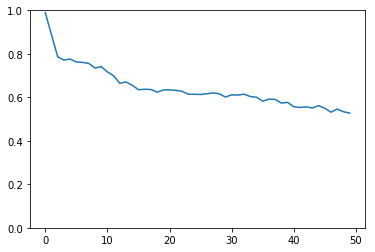

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [19]:
print(np.mean(test_accuracies))

0.643091899283386


In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()